In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go

from google.colab import files #Librería para cargar ficheros directamente en Colab
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/marketing

/content/drive/MyDrive/marketing


In [4]:
sales_df = pd.read_csv('sales_data_sample.csv', encoding='unicode_escape')

In [5]:
sales_df

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,10350,20,100.00,15,2244.40,12/2/2004 0:00,Shipped,4,12,2004,...,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Small
2819,10373,29,100.00,1,3978.51,1/31/2005 0:00,Shipped,1,1,2005,...,Torikatu 38,NaN,Oulu,NaN,90110,Finland,EMEA,Koskitalo,Pirkko,Medium
2820,10386,43,100.00,4,5417.57,3/1/2005 0:00,Resolved,1,3,2005,...,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Medium
2821,10397,34,62.24,1,2116.16,3/28/2005 0:00,Shipped,1,3,2005,...,1 rue Alsace-Lorraine,NaN,Toulouse,NaN,31000,France,EMEA,Roulet,Annette,Small


In [6]:
sales_df.dtypes

,0
ORDERNUMBER,int64
QUANTITYORDERED,int64
PRICEEACH,float64
ORDERLINENUMBER,int64
SALES,float64
ORDERDATE,object
STATUS,object
QTR_ID,int64
MONTH_ID,int64
YEAR_ID,int64


MINI RETO 1
 * Convertir la fecha del pedido en el formato de fecha y uhora usando pandas
 *

In [7]:
#Convertir la fecha del pedido en formato fecha
sales_df['ORDERDATE'] = pd.to_datetime(sales_df['ORDERDATE'])
#Comprobar el tipo de datos
sales_df.dtypes

,0
ORDERNUMBER,int64
QUANTITYORDERED,int64
PRICEEACH,float64
ORDERLINENUMBER,int64
SALES,float64
ORDERDATE,datetime64[ns]
STATUS,object
QTR_ID,int64
MONTH_ID,int64
YEAR_ID,int64


MINI RETO 2
* Cuantos elementos nulos existen en 'ADDRESSLINE2

In [8]:
#Comprobar el numero de elementos no nulos del data frame
sales_df.info()
#Comprobar el numero de elementos nulos del data frame
sales_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       2823 non-null   int64         
 1   QUANTITYORDERED   2823 non-null   int64         
 2   PRICEEACH         2823 non-null   float64       
 3   ORDERLINENUMBER   2823 non-null   int64         
 4   SALES             2823 non-null   float64       
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   STATUS            2823 non-null   object        
 7   QTR_ID            2823 non-null   int64         
 8   MONTH_ID          2823 non-null   int64         
 9   YEAR_ID           2823 non-null   int64         
 10  PRODUCTLINE       2823 non-null   object        
 11  MSRP              2823 non-null   int64         
 12  PRODUCTCODE       2823 non-null   object        
 13  CUSTOMERNAME      2823 non-null   object        
 14  PHONE             2823 n

,0
ORDERNUMBER,0
QUANTITYORDERED,0
PRICEEACH,0
ORDERLINENUMBER,0
SALES,0
ORDERDATE,0
STATUS,0
QTR_ID,0
MONTH_ID,0
YEAR_ID,0


In [9]:
df_drop = ['ADDRESSLINE2', 'ADDRESSLINE1', 'POSTALCODE', 'CITY', 'TERRITORY', 'PHONE', 'STATE', 'CONTACTFIRSTNAME', 'CONTACTLASTNAME', 'CUSTOMERNAME', 'ORDERNUMBER']
sales_df = sales_df.drop(df_drop, axis=1)
sales_df.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Motorcycles,95,S10_1678,USA,Small
1,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Motorcycles,95,S10_1678,France,Small
2,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,S10_1678,France,Medium
3,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,Motorcycles,95,S10_1678,USA,Medium
4,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,Motorcycles,95,S10_1678,USA,Medium


In [10]:
sales_df.isnull().sum()

,0
QUANTITYORDERED,0
PRICEEACH,0
ORDERLINENUMBER,0
SALES,0
ORDERDATE,0
STATUS,0
QTR_ID,0
MONTH_ID,0
YEAR_ID,0
PRODUCTLINE,0


MINI RETO 3
* Cuantos valores unicos existen en pais
* Cuantos codigos de producto unicos y lineas de productos tenemos

In [11]:
#Obtener las observaciones unicas de cada columna
sales_df.nunique()

,0
QUANTITYORDERED,58
PRICEEACH,1016
ORDERLINENUMBER,18
SALES,2763
ORDERDATE,252
STATUS,6
QTR_ID,4
MONTH_ID,12
YEAR_ID,3
PRODUCTLINE,7


Tarea 3 ANALISIS EXPLORATORIO DE LOS DATOS Y LIMPIEZA PARTE1

In [12]:
sales_df['COUNTRY'].value_counts().index

Index(['USA', 'Spain', 'France', 'Australia', 'UK', 'Italy', 'Finland',
       'Norway', 'Singapore', 'Canada', 'Denmark', 'Germany', 'Sweden',
       'Austria', 'Japan', 'Belgium', 'Switzerland', 'Philippines', 'Ireland'],
      dtype='object', name='COUNTRY')

In [13]:
sales_df['COUNTRY'].value_counts()

,count
COUNTRY,
USA,1004
Spain,342
France,314
Australia,185
UK,144
Italy,113
Finland,92
Norway,85
Singapore,79


In [14]:
def barplot_visualization(x):
  fig = plt.Figure(figsize = (12,6))
  fig = px.bar(x=sales_df[x].value_counts().index, y = sales_df[x].value_counts(), color = sales_df[x].value_counts().index)
  fig.show()

In [15]:
barplot_visualization('COUNTRY')

MINI RETO 4
* Cuantos valores de estado de pedido unico tenemos
* Tenemos conjusntos de datos balanceados Comentar el resultado y proponer soluciones para solucionar el problema

In [16]:
barplot_visualization('STATUS')

In [17]:
sales_df['STATUS'].value_counts()

,count
STATUS,
Shipped,2617
Cancelled,60
Resolved,47
On Hold,44
In Process,41
Disputed,14


In [18]:
 #Dumies
 sales_df.drop(columns = ['STATUS'], inplace =True)
 sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,Motorcycles,95,S10_1678,USA,Small
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,Motorcycles,95,S10_1678,France,Small
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,Motorcycles,95,S10_1678,France,Medium
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,Motorcycles,95,S10_1678,USA,Medium
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,Motorcycles,95,S10_1678,USA,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,Ships,54,S72_3212,Spain,Small
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,Ships,54,S72_3212,Finland,Medium
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,Ships,54,S72_3212,Spain,Medium
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,Ships,54,S72_3212,France,Small


In [19]:
barplot_visualization('PRODUCTLINE')

In [20]:
barplot_visualization('DEALSIZE')

In [21]:
#Funcion para agregar variables ficticias para remplazar las variables categoricas
def dummies(x):
  dummy = pd.get_dummies(sales_df[x])
  sales_df.drop(columns = x, inplace = True)
  return pd.concat([sales_df, dummy], axis = 1)

In [22]:
#Obtengamos variables ficticias para la columna 'PAIS'
sales_df = dummies('COUNTRY')
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,...,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,Motorcycles,95,...,False,False,False,False,False,False,False,False,False,True
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,Motorcycles,95,...,False,False,False,False,False,False,False,False,False,False
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,Motorcycles,95,...,False,False,False,False,False,False,False,False,False,False
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,Motorcycles,95,...,False,False,False,False,False,False,False,False,False,True
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,Motorcycles,95,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,Ships,54,...,False,False,False,False,False,True,False,False,False,False
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,Ships,54,...,False,False,False,False,False,False,False,False,False,False
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,Ships,54,...,False,False,False,False,False,True,False,False,False,False
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,Ships,54,...,False,False,False,False,False,False,False,False,False,False


MINI RETO #5
* Obtenemos dummies para la linea de productos y columna de tamanño de oferta
* Realizar una prueba de verificaion y ver si la transfor,macion es correcta

In [23]:
sales_df = dummies('PRODUCTLINE')
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,...,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,S10_1678,...,False,False,True,False,True,False,False,False,False,False
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,S10_1678,...,False,False,False,False,True,False,False,False,False,False
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,S10_1678,...,False,False,False,False,True,False,False,False,False,False
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,S10_1678,...,False,False,True,False,True,False,False,False,False,False
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,S10_1678,...,False,False,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,S72_3212,...,False,False,False,False,False,False,True,False,False,False
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,S72_3212,...,False,False,False,False,False,False,True,False,False,False
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,S72_3212,...,False,False,False,False,False,False,True,False,False,False
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,S72_3212,...,False,False,False,False,False,False,True,False,False,False


In [24]:
sales_df = dummies('DEALSIZE')
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,S10_1678,...,False,True,False,False,False,False,False,False,False,True
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,S10_1678,...,False,True,False,False,False,False,False,False,False,True
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,S10_1678,...,False,True,False,False,False,False,False,False,True,False
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,S10_1678,...,False,True,False,False,False,False,False,False,True,False
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,S10_1678,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,S72_3212,...,False,False,False,True,False,False,False,False,False,True
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,S72_3212,...,False,False,False,True,False,False,False,False,True,False
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,S72_3212,...,False,False,False,True,False,False,False,False,True,False
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,S72_3212,...,False,False,False,True,False,False,False,False,False,True


In [25]:
y = pd.Categorical(sales_df['PRODUCTCODE'])
y

['S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', ..., 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212']
Length: 2823
Categories (109, object): ['S10_1678', 'S10_1949', 'S10_2016', 'S10_4698', ..., 'S700_3962',
                           'S700_4002', 'S72_1253', 'S72_3212']

In [26]:
y = pd.Categorical(sales_df['PRODUCTCODE']).codes
y

array([  0,   0,   0, ..., 108, 108, 108], dtype=int8)

In [27]:
#Dado que el numero de codigo de producto tiene 109 valores unicos, si agregamos variables one-shot,
#serian 109 columnas adicionales, podemos evitarlo usando la codificacion categorica
#Esta no es la forma optima de lidiar con esto, pero es importante evitar la maldicion de dimensionalidades
sales_df['PRODUCTCODE'] = pd.Categorical(sales_df['PRODUCTCODE']).codes
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,0,...,False,True,False,False,False,False,False,False,False,True
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,0,...,False,True,False,False,False,False,False,False,False,True
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,0,...,False,True,False,False,False,False,False,False,True,False
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,0,...,False,True,False,False,False,False,False,False,True,False
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,0,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,108,...,False,False,False,True,False,False,False,False,False,True
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,108,...,False,False,False,True,False,False,False,False,True,False
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,108,...,False,False,False,True,False,False,False,False,True,False
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,108,...,False,False,False,True,False,False,False,False,False,True


# TAREA #4 ANALISIS EXPLORATORIO DE LOS DATOS Y LIMPIEZA - PARTE 2

In [28]:
#Agrupamos los datos segun la fecha del pedido
sales_df_group = sales_df.groupby(by = 'ORDERDATE').sum()
sales_df_group

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
ORDERDATE,,,,,,,,,,,,,,,,,,,,,
2003-01-06,151,288.78,10,12133.25,4,4,8012,363,174,0,...,0,0,0,0,0,0,4,0,2,2
2003-01-09,142,284.96,10,11432.34,4,4,8012,372,181,0,...,0,0,0,0,0,0,4,0,2,2
2003-01-10,80,150.14,3,6864.05,2,2,4006,155,37,0,...,0,0,0,0,0,0,2,0,1,1
2003-01-29,541,1417.54,136,54702.00,16,16,32048,1695,723,0,...,3,0,0,0,0,7,6,0,10,6
2003-01-31,443,1061.89,91,44621.96,13,13,26039,1365,720,0,...,7,0,0,0,2,4,0,0,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-05-13,259,561.18,21,31821.90,12,30,12030,728,101,0,...,0,6,0,0,0,0,0,2,3,1
2005-05-17,509,1269.43,105,59475.10,28,70,28070,1669,462,0,...,14,0,0,0,0,0,0,2,8,4
2005-05-29,607,1148.40,94,51233.18,30,75,30075,1328,797,13,...,7,0,0,0,0,0,8,0,8,7


#MINI RETO 6
* Segun los datos ¿Cuantos alcanzan a su punto maximo las ventas (en que mas)?
* Apoya tu respuesta con visualizaciones /graficos

In [29]:
fig = px.line(x = sales_df_group.index, y= sales_df_group.SALES, title = 'Sales')
fig.show()

In [30]:
#Podemos eliminar 'ORDERDATE' y quedarnos con el resto de datos relacionados con la fecha como 'MONTH'
sales_df.drop("ORDERDATE", axis=1, inplace=True)
sales_df.shape

(2823, 38)

# MINI RETO #7
* Representar la matriz de correlacion entre variables
* Comentar los resultados de la matriz

<Axes: >

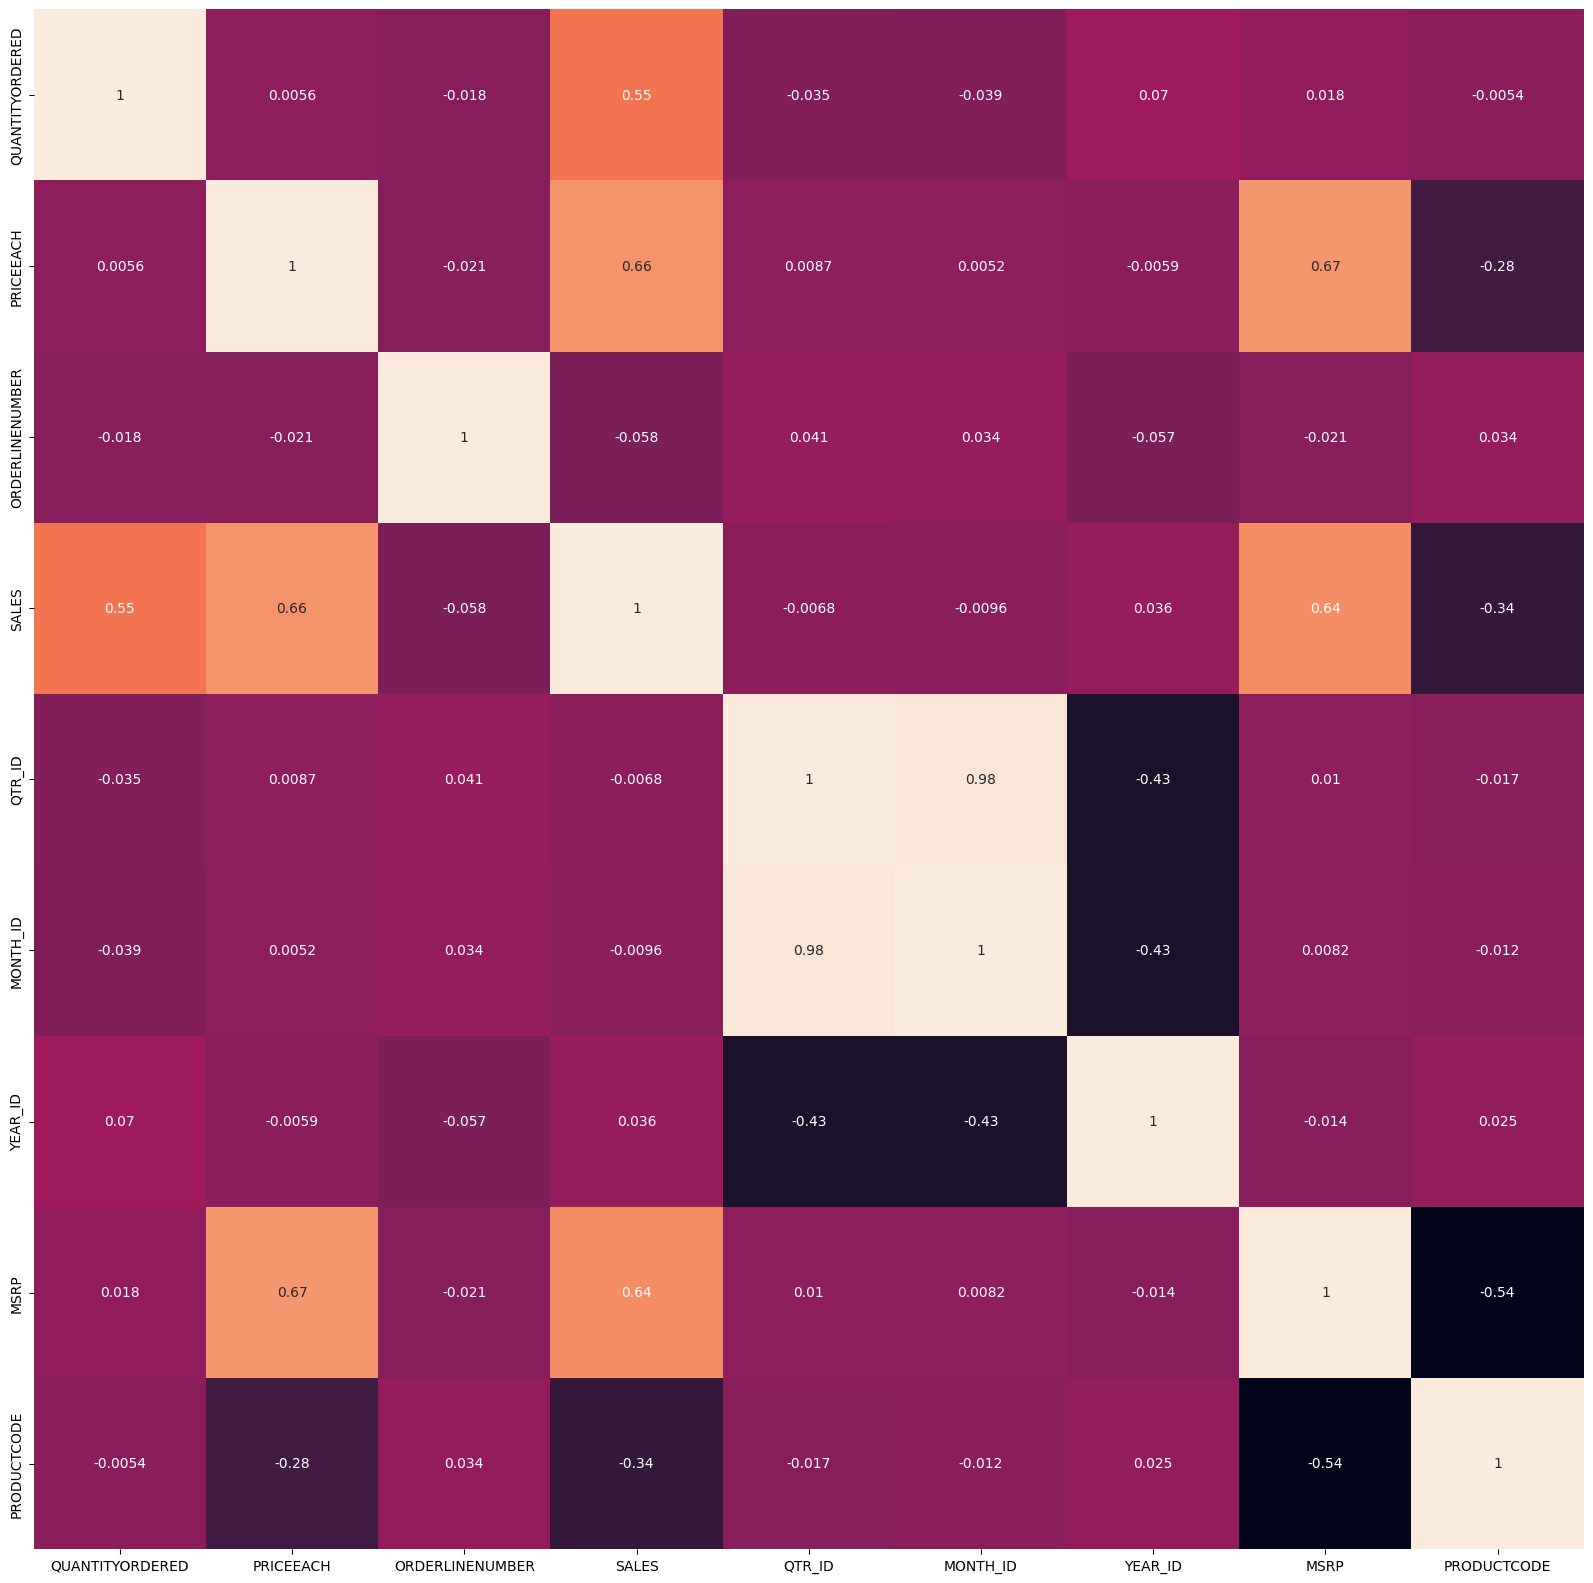

In [31]:
plt.figure(figsize=(20, 20))
corr_matrix = sales_df.iloc[:,:9].corr()
sns.heatmap(corr_matrix, annot=True, cbar = False)

In [32]:
#Parece que el id trimestre y el id mes estan altamnete correlacionados
#Dejemos 'QTR_ID o Mont_Id

sales_df.drop(['QTR_ID'], axis = 1, inplace = True)
sales_df.shape

(2823, 37)

In [33]:
#Vamos a representar distribuciones
# Distplot muestra el (1) histograma, (2) kde plot y (3) rug plot.
# (1) Histograma: es una visualización gráfica de datos que usa barras con varias alturas. Cada barra agrupa los números en rangos y las barras más altas muestran que hay más datos en ese rango.
# (2) Densidad: la estimación de la función de densidad se utiliza para visualizar la densidad de probabilidad de una variable continua.
# (3) Gráfico de alfombra: gráfico de datos para una única variable cuantitativa, que se muestra como marcas a lo largo de un eje (gráfico de dispersión unidimensional).

import plotly.figure_factory as ff
plt.figure(figsize=(10, 10))
for i in range(8):
  if sales_df.columns[i] != 'ORDERLINENUMBER':
    col_name = sales_df.columns[i]
    fig = ff.create_distplot([sales_df[col_name].apply(lambda x: float(x))],['displot'])
    fig.update_layout(title_text = col_name)
    fig.show()

#Longtale(lo q tienes y vendes y lo q vendes )

<Figure size 1000x1000 with 0 Axes>

In [34]:
#KPI kiy performance indcators indixadores clave de rendimiento
#Visualizar la relacion entre variables usando parcelas
plt.figure(figsize=(15,15))

fig = px.scatter_matrix(sales_df,
                        dimensions = sales_df.columns[:8], color = 'MONTH_ID')
fig.update_layout(
    title = 'Sales Data',
    height = 1100,
    width = 1100
)
fig.show()
#Existe una tendencia entre 'SLAES' y 'QUANTITYORDERED'
#Existe una tenfdencia entre 'MSRP' y 'PTRICEACH'
#Existe una tendencia

<Figure size 1500x1500 with 0 Axes>

# TAREA #6 Encuentre el numero optimo de clusters utilizando

In [35]:
#Escalamos los datos
scaler = StandardScaler()
sales_df_scaled = scaler.fit_transform(sales_df)

In [36]:
sales_df_scaled.shape

(2823, 37)

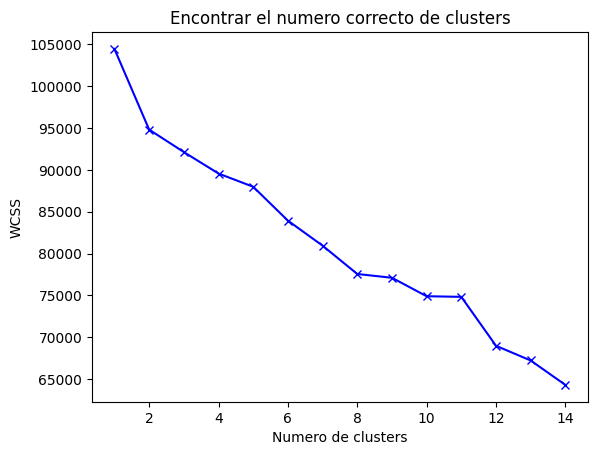

In [37]:
scores = []
range_values = range(1,15)
for i in range_values:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(sales_df_scaled)
    scores.append(kmeans.inertia_)#ineritia es la suma de los cuadrados de las distancias de las observaciones al centro del cluster mas cercacno

plt.plot(range_values, scores, 'bx-')
plt.title('Encontrar el numero correcto de clusters')
plt.xlabel('Numero de clusters')
plt.ylabel('WCSS')
plt.show()

# TAREA #7 Aplicar el metodo de K-means

In [38]:
#Agrupar los datos usando k-means
kmeans = KMeans(5)
kmeans.fit(sales_df_scaled)
labels = kmeans.labels_

In [39]:
labels

array([3, 3, 4, ..., 1, 3, 1], dtype=int32)

In [40]:
kmeans.cluster_centers_.shape

(5, 37)

In [41]:
#Echamos un vitazo a los centros de los closters
cluster_center = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
cluster_center

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,-0.136621,-0.007421,-0.019499,-0.078801,0.048637,0.001609,-0.018750,-0.168952,3.776170,-0.140961,...,-0.118124,0.072390,0.086014,-0.261427,-0.134269,0.004808,0.239741,-0.077568,-0.050797,0.086707
1,0.093143,-0.060652,0.171595,-0.214127,-0.084016,0.171831,-0.380434,1.034086,-0.264819,-0.034562,...,-0.721812,-0.364452,2.167909,0.488750,-0.167454,-0.345470,-0.523371,-0.165670,0.066554,0.009433
2,0.086176,0.203203,-0.037639,0.106472,0.100728,-0.087941,0.038989,-0.064409,-0.264819,-0.011762,...,-0.721812,-0.364452,-0.348674,-0.300637,-0.167454,2.894605,-0.523371,-0.149169,0.190948,-0.123058
3,-0.456528,-0.782445,0.028996,-0.828822,0.013999,-0.031216,-0.623368,0.222707,-0.264819,-0.014995,...,-0.006414,0.112447,-0.348674,0.192686,0.159884,-0.341945,0.247371,-0.242672,-0.980703,1.096370
4,0.353982,0.622534,-0.064462,0.745456,-0.019564,-0.004922,0.632188,-0.461298,-0.264819,0.049957,...,0.432458,0.099389,-0.304770,-0.191730,-0.016626,-0.345470,0.048047,0.305242,0.759390,-0.902963


In [42]:
#Para entender que es lo que realizan los numeros realicemos una transformaxion invers a
cluster_center_unscaled = scaler.inverse_transform(cluster_center)
cluster_center_unscaled = pd.DataFrame(data = cluster_center_unscaled, columns = [sales_df.columns])
cluster_center_unscaled

# Clúster 0 (más alto): este grupo representa a los clientes que compran artículos en una gran cantidad centrada en ~ 47,
# compran artículos en todos los rangos de precios inclinándose hacia artículos de alto precio de ~ 99.
#También corresponden a las ventas totales más altas alrededor de ~ 8296 y están activas durante todo el año. Son los mayores compradores de productos con un MSRP alto ~ 158.

# Clúster 1: este grupo representa a los clientes que compran artículos en cantidades variables ~ 35,
#tienden a comprar artículos de alto precio ~ 96. Sus ventas son un poco mejores en promedio ~ 4435, compran productos con el segundo MSRP más alto de ~ 133.

# Clúster 2 (más bajo): este grupo representa a los clientes que compran artículos en cantidades bajas ~ 30.
# Suelen comprar artículos de bajo precio ~ 68. Sus ventas ~ 2044 son más bajas que las de otros grupos y son extremadamente activos durante la temporada navideña.
# Compran productos con un MSRP bajo ~ 75.

# Clúster 3: este grupo representa a los clientes que solo están activos durante las vacaciones. compran en menor cantidad ~ 35,
# pero tienden a comprar artículos de precio promedio alrededor de ~ 86. También corresponden a ventas totales más bajas alrededor de ~ 3673, tienden a comprar artículos con MSRP alrededor de 102.

# Clúster 4: este grupo representa a los clientes que compran artículos en cantidad variable ~ 39, tienden a comprar artículos de precio promedio ~ 94. Sus ventas ~ 4280.

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,33.762162,83.508865,6.383784,3408.773514,7.270270,2003.816216,99.962162,48.437838,1.000000e+00,-6.245005e-17,...,2.864865e-01,1.405405e-01,1.351351e-01,1.081081e-02,5.405405e-03,1.081081e-01,3.135135e-01,3.783784e-02,4.648649e-01,0.497297
1,36.000000,82.435147,7.191176,3159.565853,6.785294,2003.935294,85.429412,86.429412,-2.775558e-17,1.470588e-02,...,-9.992007e-16,-9.992007e-16,7.823529e-01,2.176471e-01,-1.700029e-16,-4.440892e-16,-1.082467e-15,1.764706e-02,5.235294e-01,0.458824
2,35.932143,87.757286,6.307143,3749.961464,7.460714,2003.753571,102.282143,51.739286,-2.359224e-16,1.785714e-02,...,-4.996004e-16,-7.494005e-16,-2.359224e-16,3.469447e-16,-1.491862e-16,1.000000e+00,-1.665335e-16,2.142857e-02,5.857143e-01,0.392857
3,30.646355,67.876083,6.588683,2027.581447,7.143634,2003.793254,75.668118,60.806311,5.551115e-16,1.741023e-02,...,3.394995e-01,1.534276e-01,-1.249001e-16,1.360174e-01,5.331882e-02,1.088139e-03,3.166485e-01,8.812395e-16,-1.110223e-15,1.000000
4,38.540491,96.215487,6.193813,4926.675887,7.020928,2003.811647,126.117379,39.205641,6.106227e-16,2.638763e-02,...,5.477707e-01,1.492266e-01,1.364877e-02,3.002730e-02,2.456779e-02,1.748601e-15,2.347589e-01,1.255687e-01,8.698817e-01,0.004550


In [43]:
labels.shape

(2823,)

In [44]:
labels.max()

np.int32(4)

In [45]:
labels.min()

np.int32(0)

In [46]:
y_kmeans = kmeans.fit_predict(sales_df_scaled)
y_kmeans

array([0, 0, 4, ..., 4, 0, 4], dtype=int32)

In [47]:
y_kmeans.shape

(2823,)

In [48]:
#Agregamos una etiqueta que closter corresponde a cada pounto de datos
sales_df_cluster = pd.concat([sales_df,pd.DataFrame({'cluster':labels})], axis=1)
sales_df_cluster

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,cluster
0,30,95.70,2,2871.00,2,2003,95,0,False,False,...,True,False,False,False,False,False,False,False,True,3
1,34,81.35,5,2765.90,5,2003,95,0,False,False,...,True,False,False,False,False,False,False,False,True,3
2,41,94.74,2,3884.34,7,2003,95,0,False,False,...,True,False,False,False,False,False,False,True,False,4
3,45,83.26,6,3746.70,8,2003,95,0,False,False,...,True,False,False,False,False,False,False,True,False,4
4,49,100.00,14,5205.27,10,2003,95,0,False,False,...,True,False,False,False,False,False,False,True,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,12,2004,54,108,False,False,...,False,False,True,False,False,False,False,False,True,3
2819,29,100.00,1,3978.51,1,2005,54,108,False,False,...,False,False,True,False,False,False,False,True,False,1
2820,43,100.00,4,5417.57,3,2005,54,108,False,False,...,False,False,True,False,False,False,False,True,False,1
2821,34,62.24,1,2116.16,3,2005,54,108,False,False,...,False,False,True,False,False,False,False,False,True,3


In [49]:
sales_df['ORDERLINENUMBER'] = sales_df['ORDERLINENUMBER'].apply(lambda x: float(x))

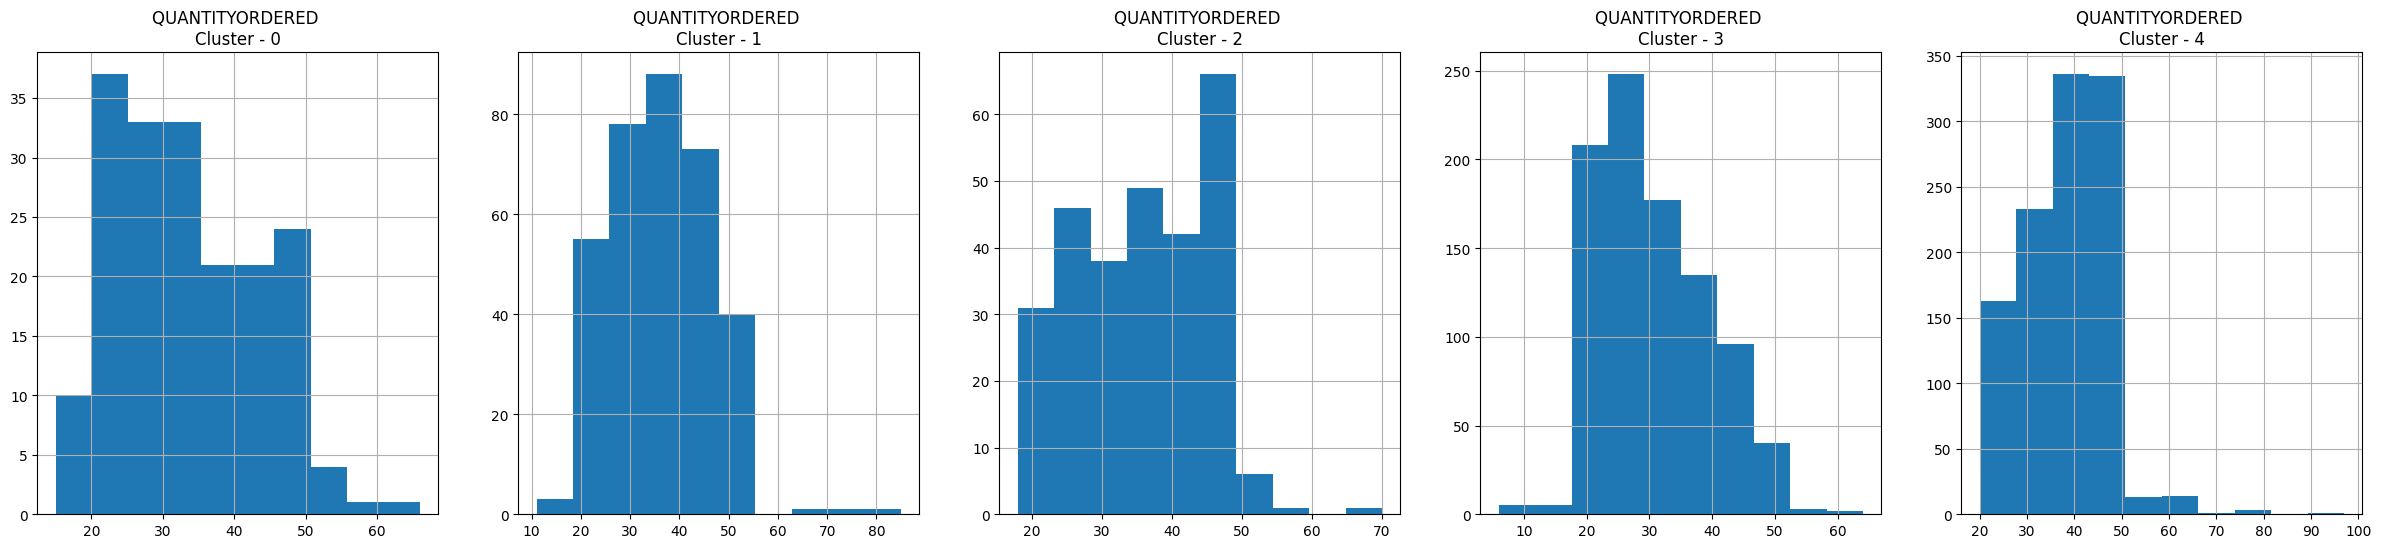

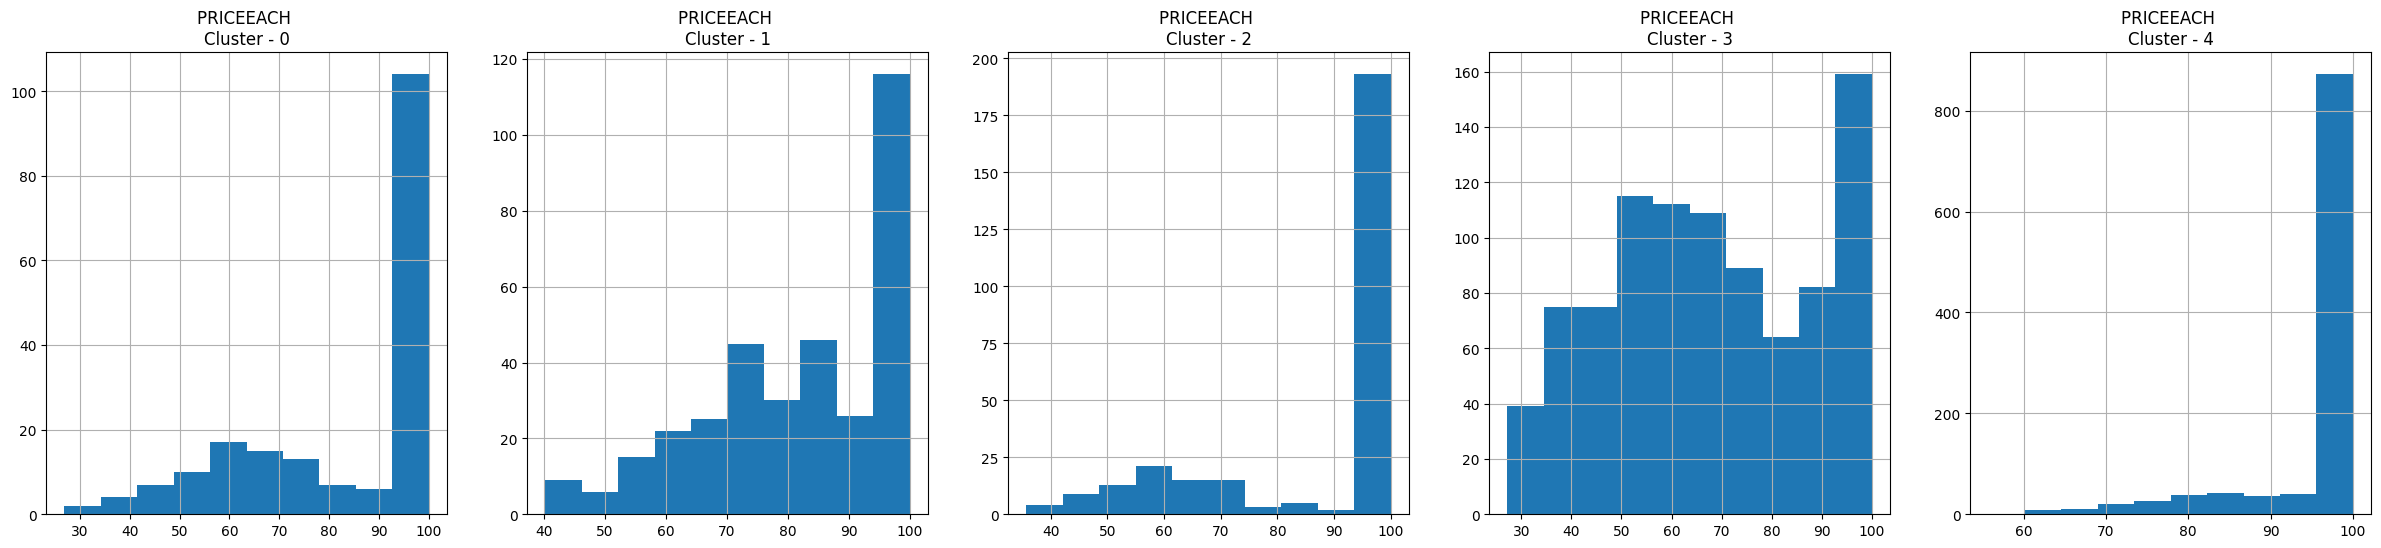

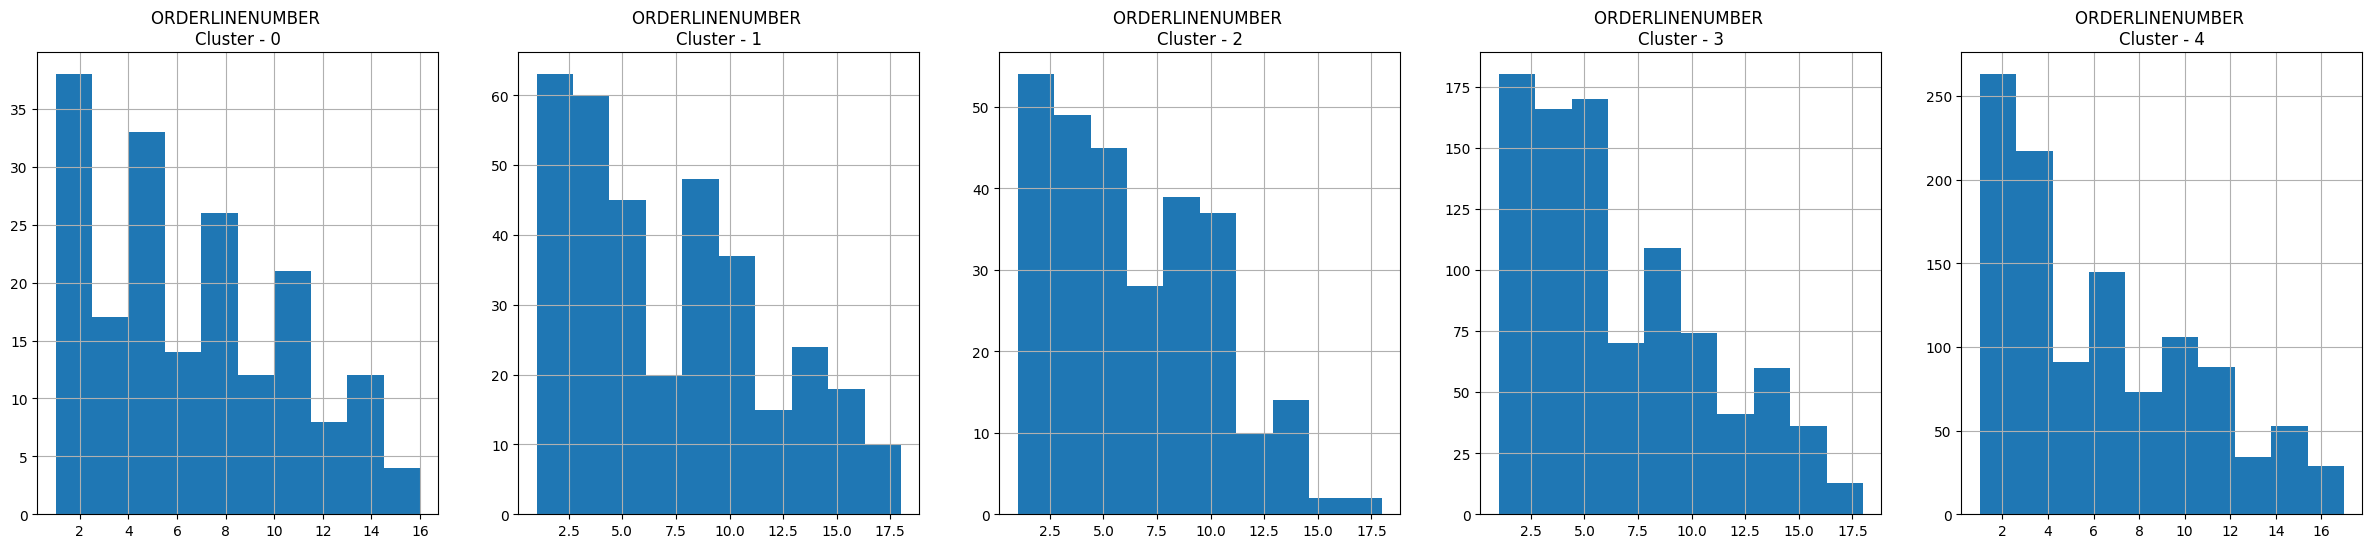

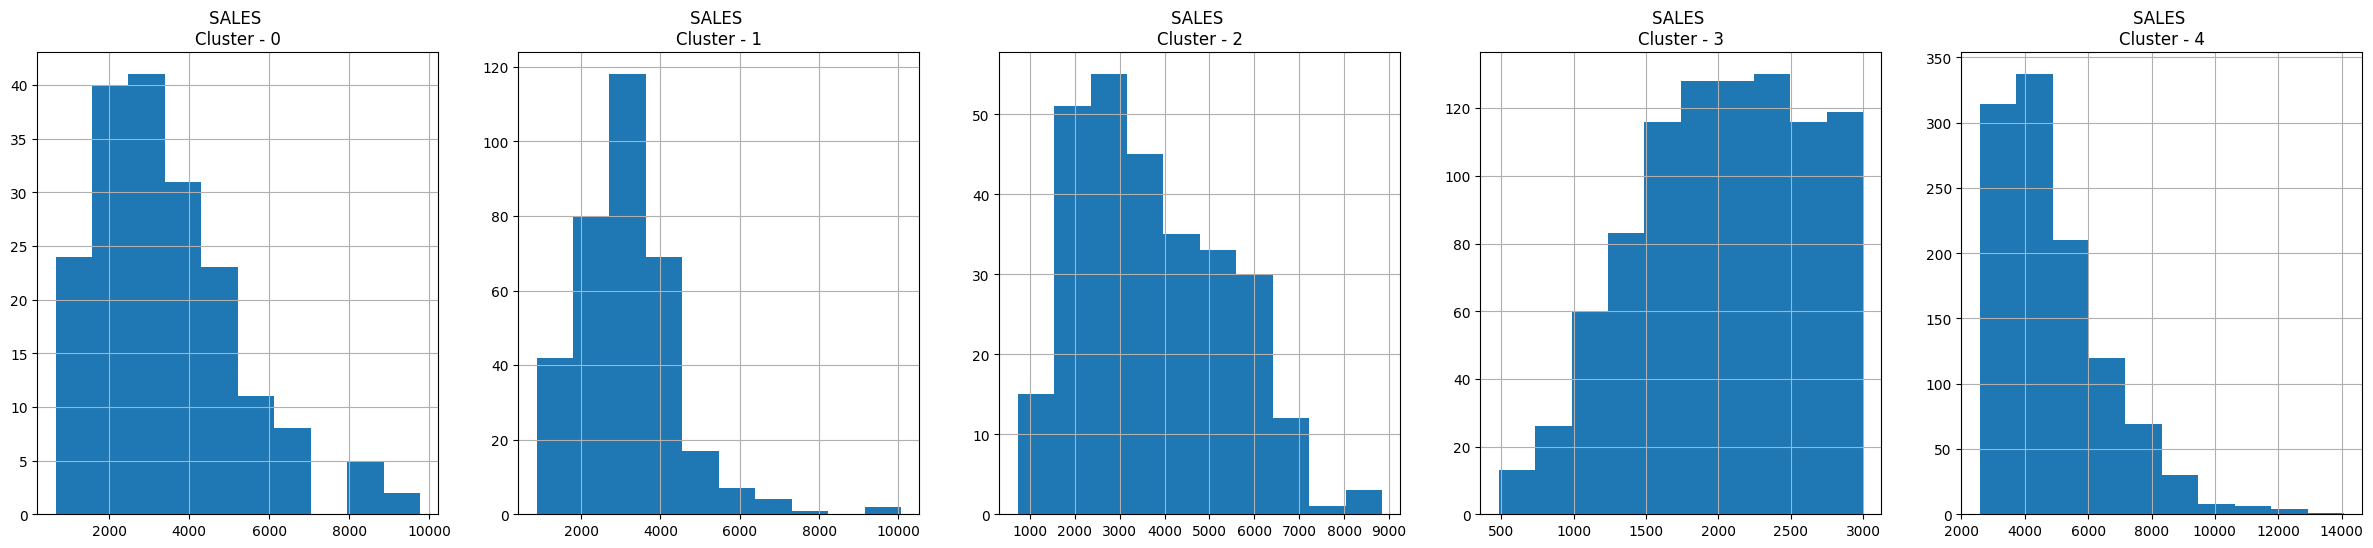

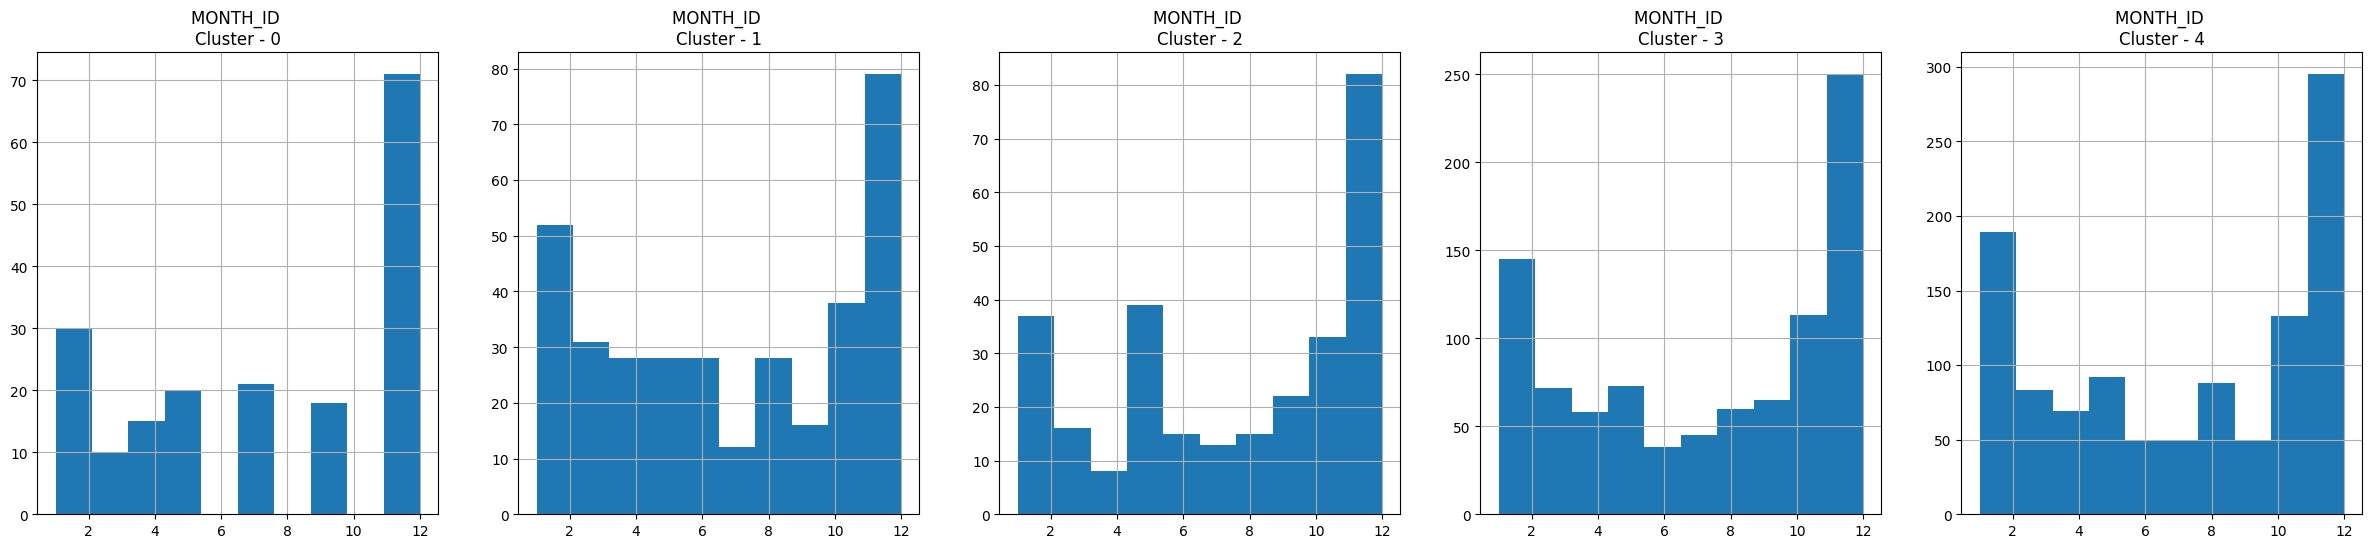

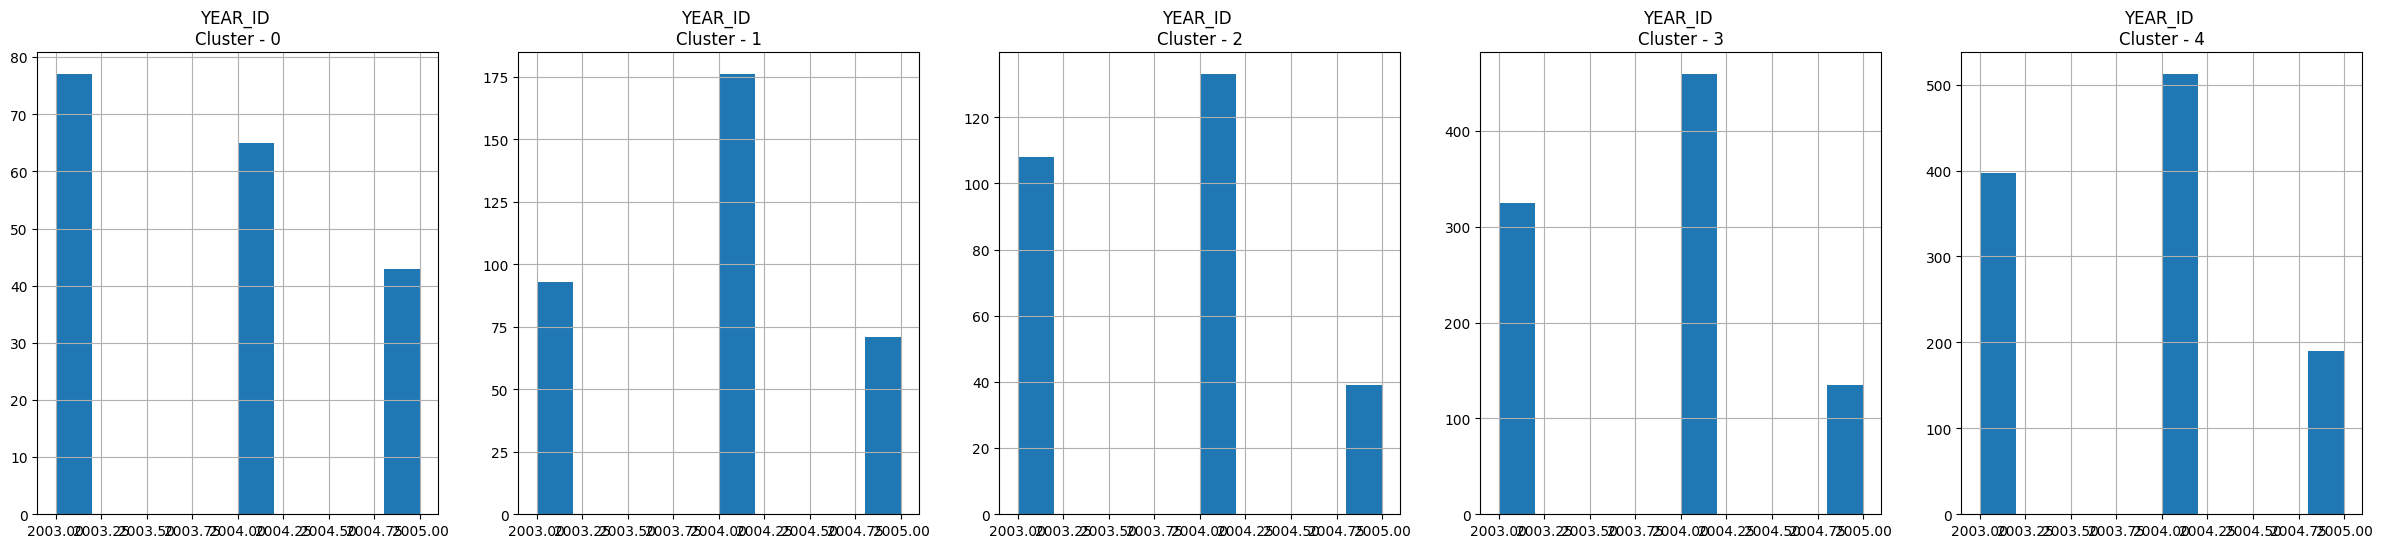

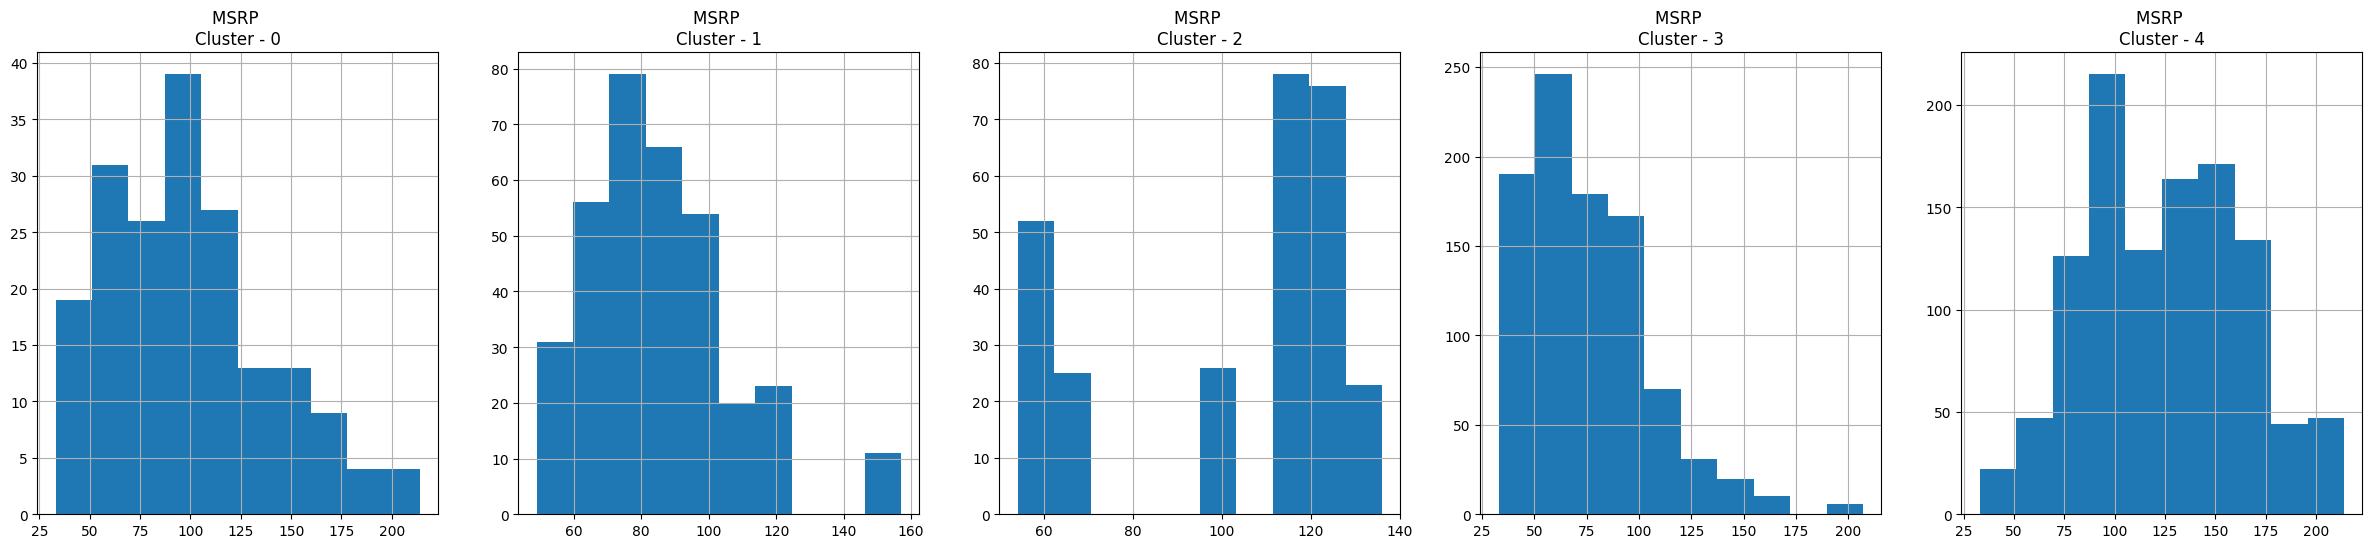

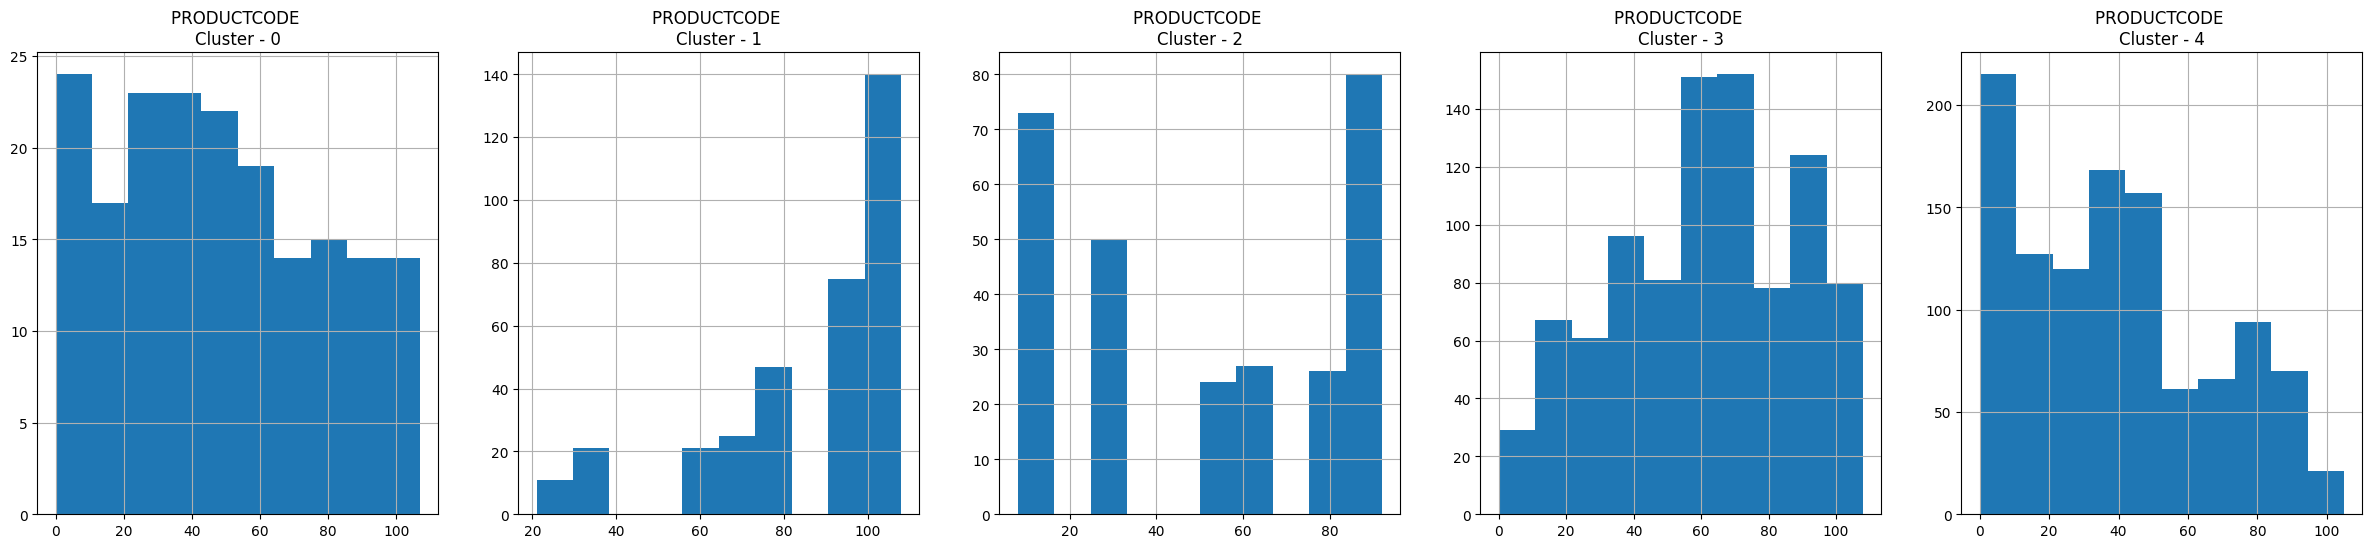

In [50]:
#Representar un histograma para cada caracteristica segun el cluster al que pertenece
for i in sales_df.columns[:8]:
  plt.figure(figsize=(30,6))
  for j in range(5):
    plt.subplot(1,5,j+1)
    cluster = sales_df_cluster[sales_df_cluster['cluster'] == j]
    cluster[i].hist()
    plt.title('{} \nCluster - {}'.format(i,j))
  plt.show()

#TAREA #8 Aplicar el analisis de componnetes principales y visualizar los resultados

In [51]:
#Reducir los daros a 3 dinmensiones usando PCA para visualizar los clusters
pca = PCA(n_components=3)
principal_comp = pca.fit_transform(sales_df_scaled)
principal_comp

array([[-0.48631933,  1.19523199, -1.00267727],
       [-0.78465471,  1.03283188, -1.4162651 ],
       [ 1.43146434, -0.12199648, -0.28129104],
       ...,
       [ 0.38985361, -4.12946409,  0.06056817],
       [-2.78886764, -2.38601395, -1.54986594],
       [-0.7054888 , -3.31242744,  0.51890644]])

In [52]:
pca_df = pd.DataFrame(data = principal_comp, columns = ['pca1', 'pca2', 'pca3'])


In [53]:
pca_df.head()

,pca1,pca2,pca3
0,-0.486319,1.195232,-1.002677
1,-0.784655,1.032832,-1.416265
2,1.431464,-0.121996,-0.281291
3,1.288425,0.218280,0.579360
4,1.976022,0.141698,1.061314


In [54]:
#Concatenar las etiquetas de los clusters al dataframe
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df

,pca1,pca2,pca3,cluster
0,-0.486319,1.195232,-1.002677,3
1,-0.784655,1.032832,-1.416265,3
2,1.431464,-0.121996,-0.281291,4
3,1.288425,0.218280,0.579360,4
4,1.976022,0.141698,1.061314,4
...,...,...,...,...
2818,-2.450314,-1.113172,1.523553,3
2819,-0.158247,-3.709748,-0.640182,1
2820,0.389854,-4.129464,0.060568,1
2821,-2.788868,-2.386014,-1.549866,3


In [55]:
#Visualizar los clusters con 3D-Scatterplot
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3',
                    color = 'cluster', symbol = 'cluster', size_max = 18, opacity=0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))
fig.show()

In [56]:
#Que significa este tipo de grafico
#tipos de clienets
#oro molido por que

MINI RETO #8

In [57]:
pca = PCA(n_components = 2)
principal_comp = pca.fit_transform(sales_df_scaled)

pca_df

,pca1,pca2,pca3,cluster
0,-0.486319,1.195232,-1.002677,3
1,-0.784655,1.032832,-1.416265,3
2,1.431464,-0.121996,-0.281291,4
3,1.288425,0.218280,0.579360,4
4,1.976022,0.141698,1.061314,4
...,...,...,...,...
2818,-2.450314,-1.113172,1.523553,3
2819,-0.158247,-3.709748,-0.640182,1
2820,0.389854,-4.129464,0.060568,1
2821,-2.788868,-2.386014,-1.549866,3


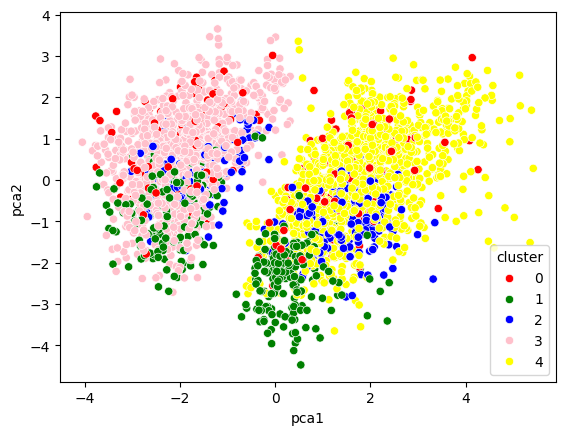

In [58]:
pca = PCA(n_components= 2)
principal_comp = pca.fit_transform(sales_df_scaled)

pca_df = pd.DataFrame(data = principal_comp, columns=['pca1', 'pca2'])
pca_df =pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)

ax = sns.scatterplot(x = 'pca1', y = 'pca2', hue = 'cluster', data = pca_df,
                     palette = ["red", "green", "blue", "pink", "yellow"])
plt.show()

# Aplicar autocoders realizar reduccion de dimencionalidad usando autoencoders


In [59]:
sales_df.shape

(2823, 37)

In [60]:
input_df = Input(shape = (37,))
x = Dense(50, activation = 'relu')(input_df)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
encoded = Dense(8,activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
decoded = Dense(37, kernel_initializer = 'glorot_uniform')(x)

autoencoder = Model(input_df, decoded)
encoder = Model(input_df, encoded)
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [62]:
autoencoder.fit(sales_df_scaled, sales_df_scaled, epochs = 100, batch_size = 128, verbose=3)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [66]:
autoencoder.save_weights('autoencoder_1.weights.h5')


In [67]:
pred = encoder.predict(sales_df_scaled)

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


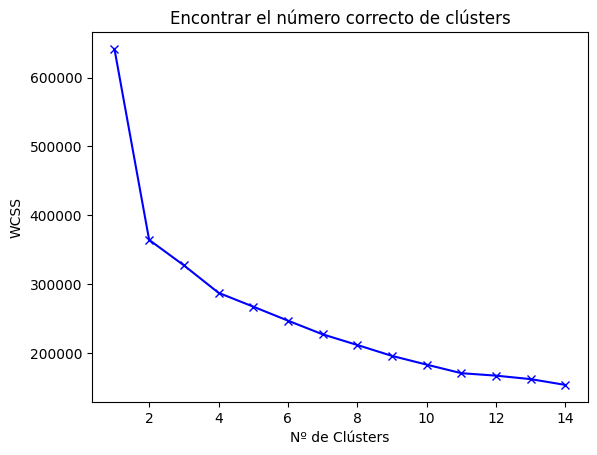

In [68]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(pred)
  scores.append(kmeans.inertia_)

plt.plot(range_values, scores, 'bx-')
plt.title('Encontrar el número correcto de clústers')
plt.xlabel('Nº de Clústers')
plt.ylabel('WCSS')
plt.show()

In [69]:
kmeans = KMeans(3)
kmeans.fit(pred)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(sales_df_scaled)

In [70]:
df_cluster_dr = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster_dr.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,cluster
0,30,95.70,2.0,2871.00,2,2003,95,0,False,False,...,True,False,False,False,False,False,False,False,True,0
1,34,81.35,5.0,2765.90,5,2003,95,0,False,False,...,True,False,False,False,False,False,False,False,True,0
2,41,94.74,2.0,3884.34,7,2003,95,0,False,False,...,True,False,False,False,False,False,False,True,False,0
3,45,83.26,6.0,3746.70,8,2003,95,0,False,False,...,True,False,False,False,False,False,False,True,False,0
4,49,100.00,14.0,5205.27,10,2003,95,0,False,False,...,True,False,False,False,False,False,False,True,False,0


In [71]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
cluster_centers

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,0.391373,0.604036,-0.044044,0.674928,-0.001371,0.001173,0.482822,-0.236197,-0.015080,0.016014,...,0.119134,-0.006824,-0.056824,-0.045489,-0.058473,0.042231,-0.067284,0.207731,0.810564,-0.909460
1,-0.467556,-0.727515,0.041991,-0.810906,0.013663,-0.007850,-0.586814,0.293816,0.024505,-0.015726,...,-0.176357,0.017055,0.076506,0.061769,0.074059,-0.042112,0.093284,-0.242672,-0.980703,1.096370
2,-0.032713,0.191391,0.439377,0.132130,-0.492927,0.264328,0.369955,-0.457595,-0.264819,-0.140961,...,1.385402,-0.364452,-0.348674,-0.300637,-0.167454,-0.345470,-0.523371,-0.242672,0.438921,-0.328996


In [72]:
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
cluster_centers

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,...,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,38.904668,95.842373,6.280079,4796.795332,7.087442,2003.815911,120.115713,46.314267,6.180145e-02,2.169625e-02,...,0.399080,1.150559e-01,9.072978e-02,7.034845e-02,1.775148e-02,1.196581e-01,1.873767e-01,1.032216e-01,8.954635e-01,0.001315
1,30.538946,68.984052,6.643588,2060.574028,7.142408,2003.809599,77.136900,63.051928,7.159717e-02,1.730921e-02,...,0.258851,1.227380e-01,1.321794e-01,9.992132e-02,3.933910e-02,9.362707e-02,2.533438e-01,-1.110223e-16,-1.054712e-15,1.000000
2,34.774194,87.519032,8.322581,3797.211613,5.290323,2004.000000,115.580645,39.322581,1.387779e-17,1.040834e-17,...,1.000000,5.551115e-17,-2.775558e-17,1.387779e-17,3.469447e-18,5.551115e-17,-2.775558e-17,4.857226e-17,7.096774e-01,0.290323


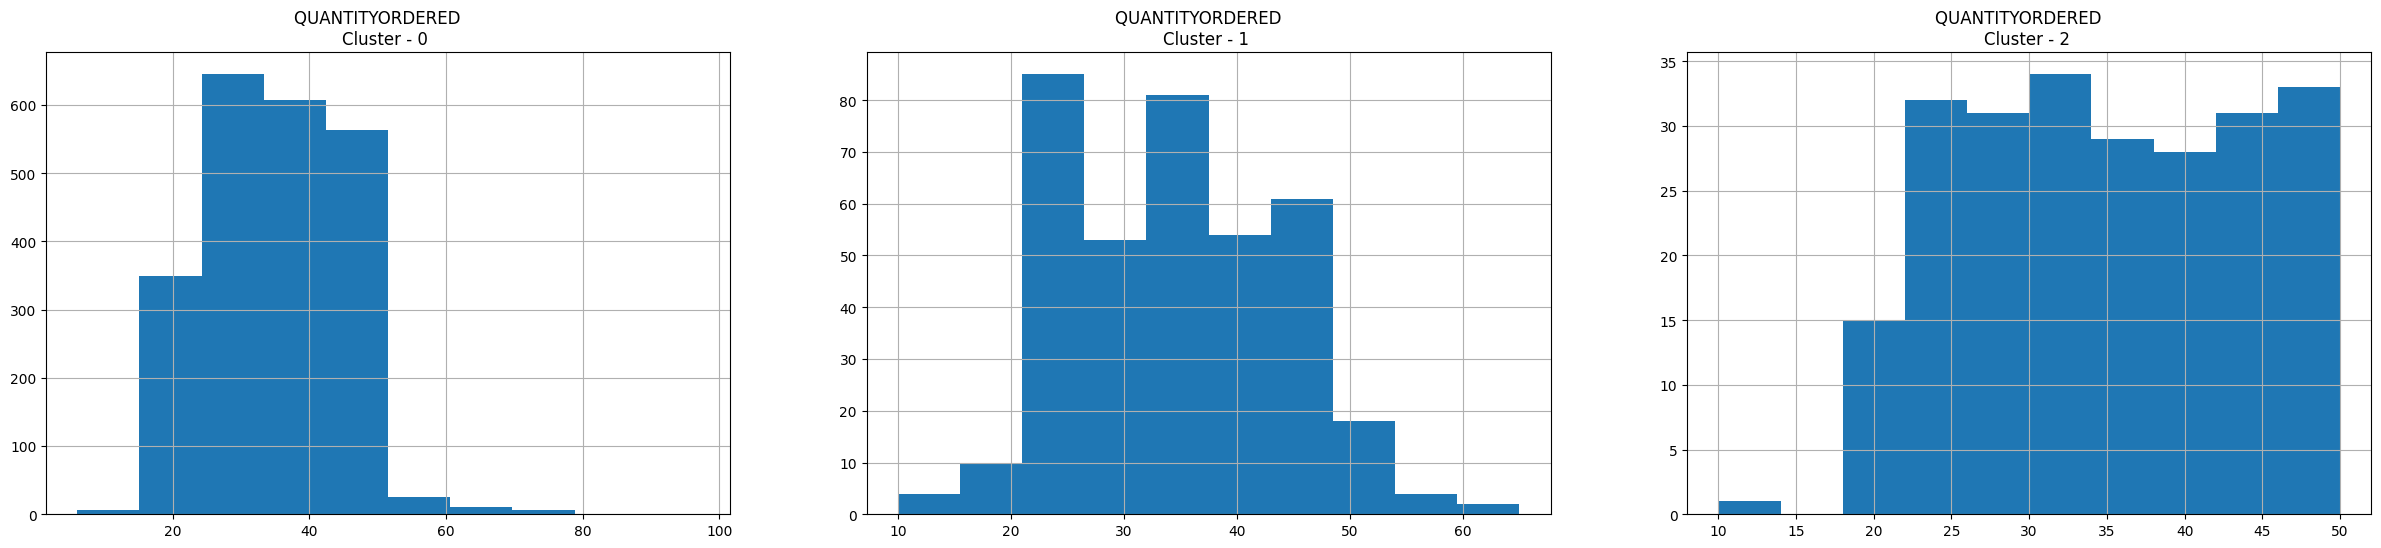

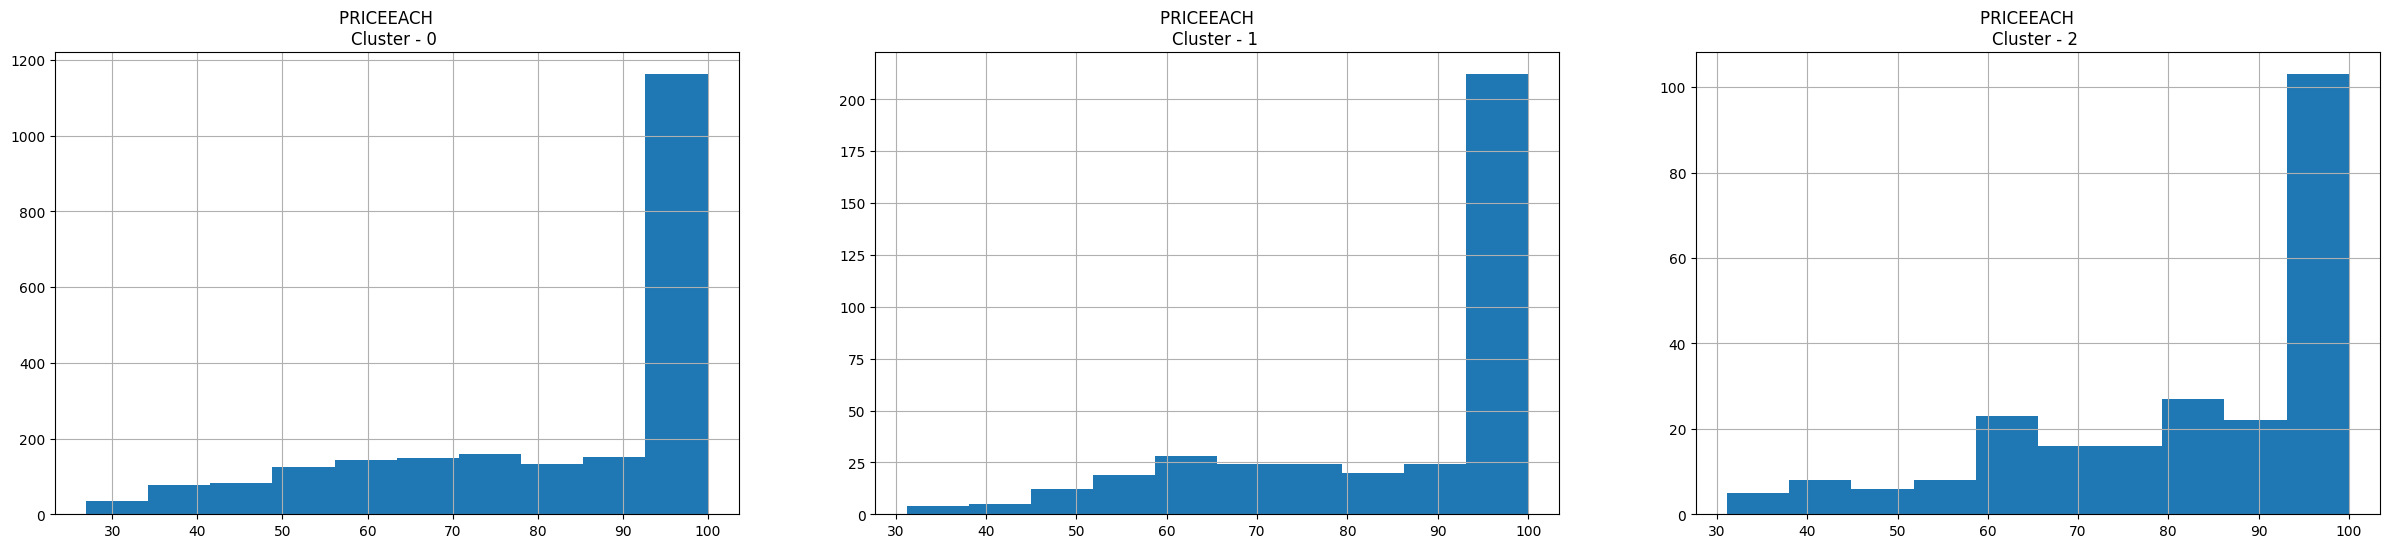

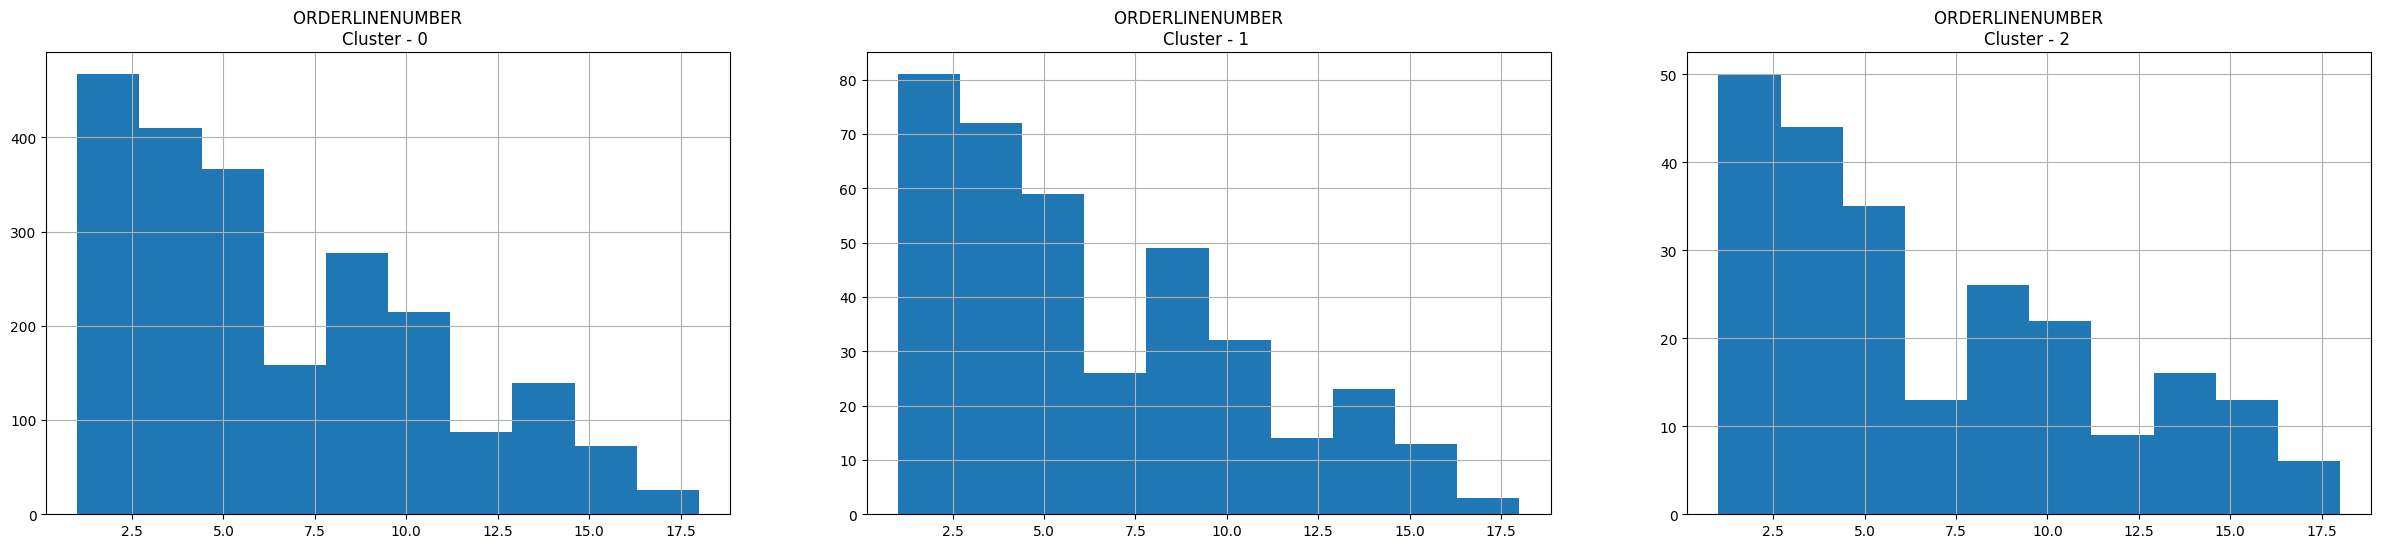

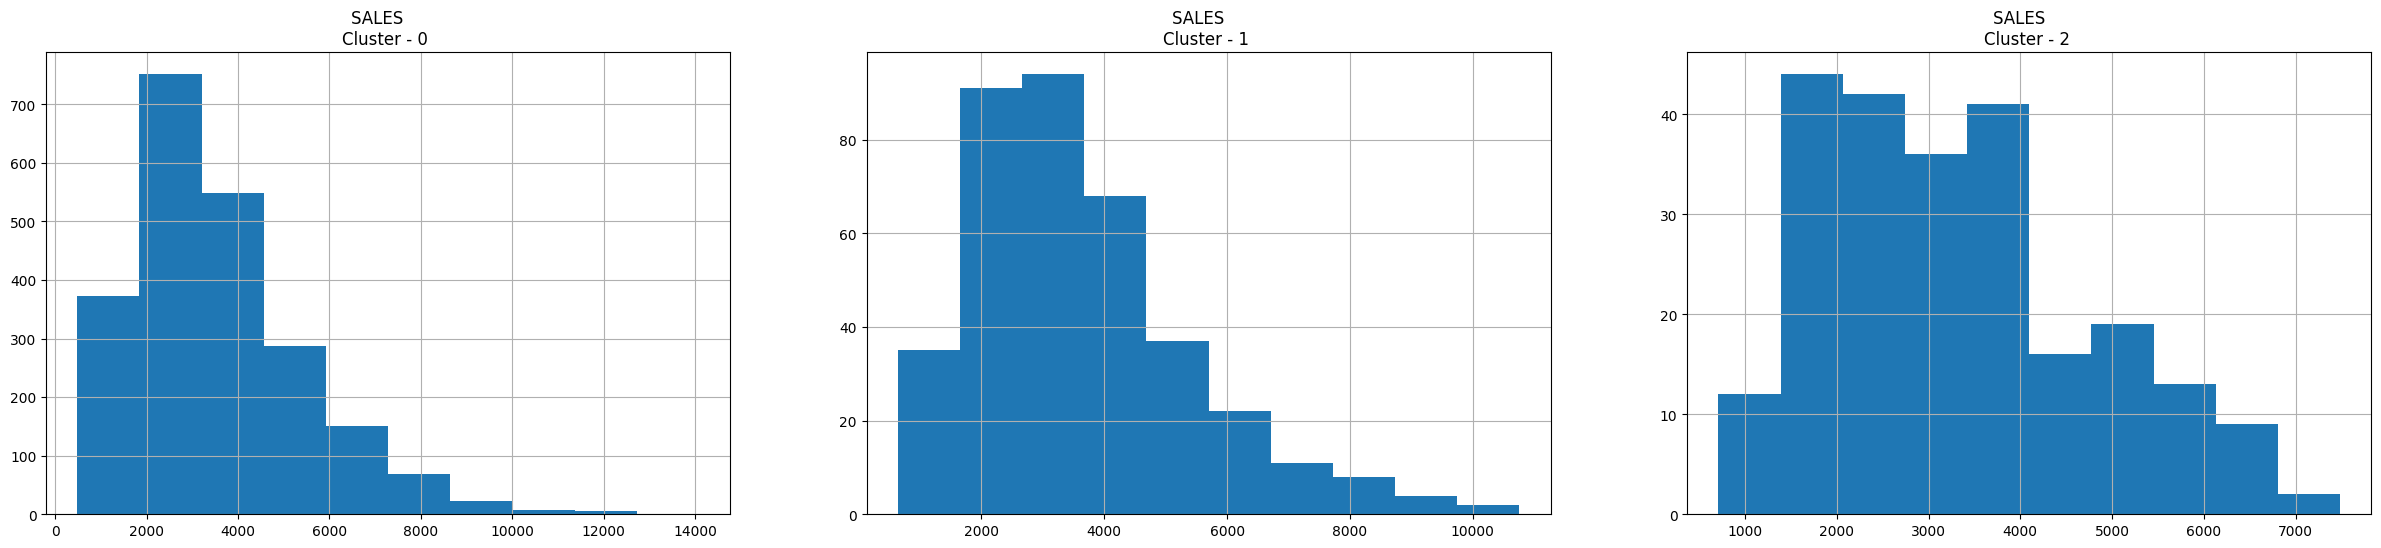

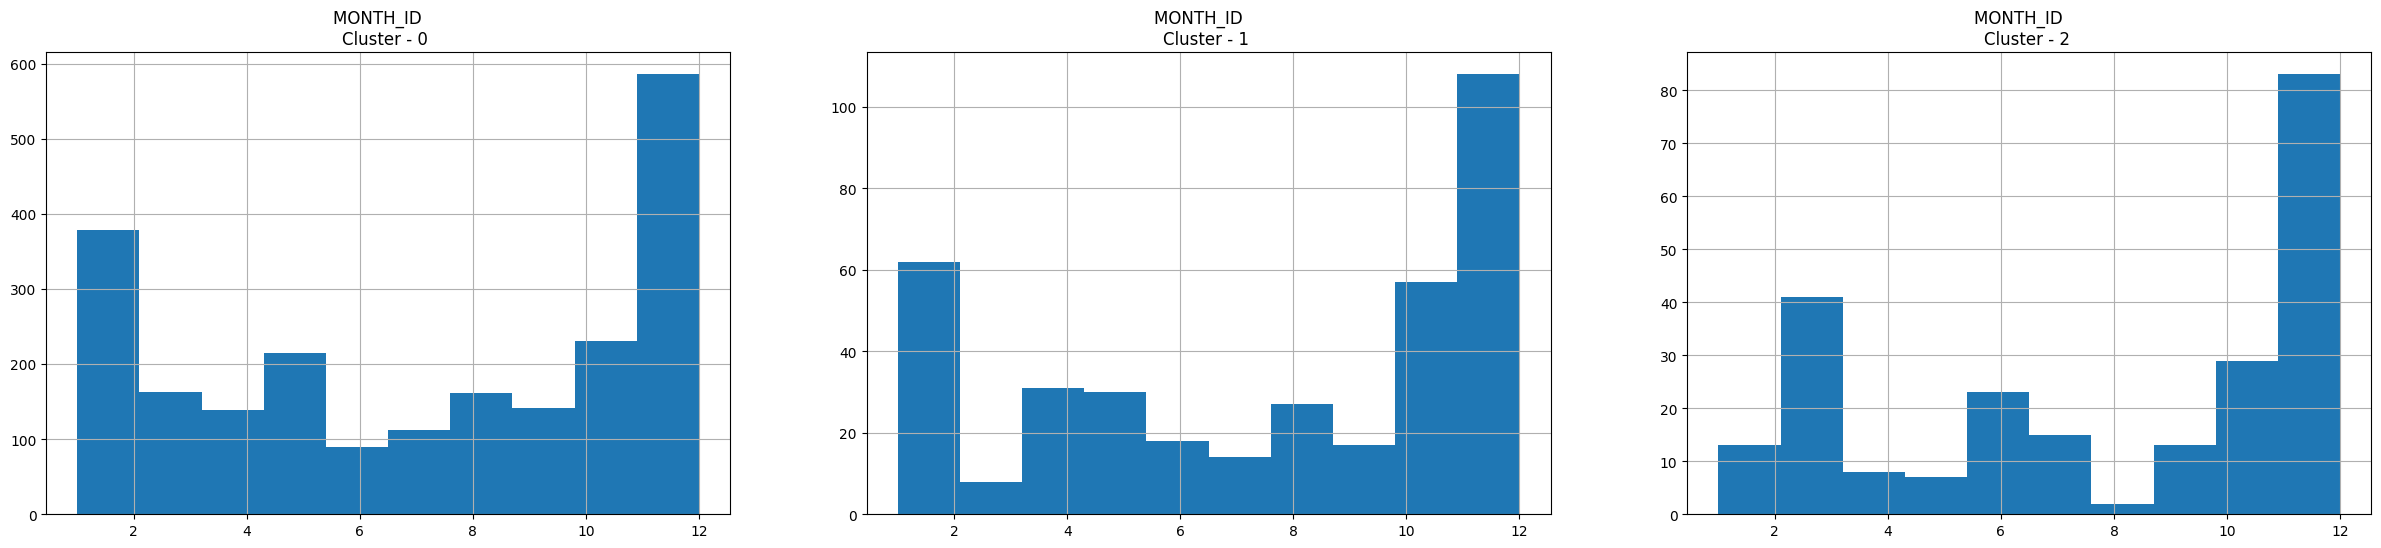

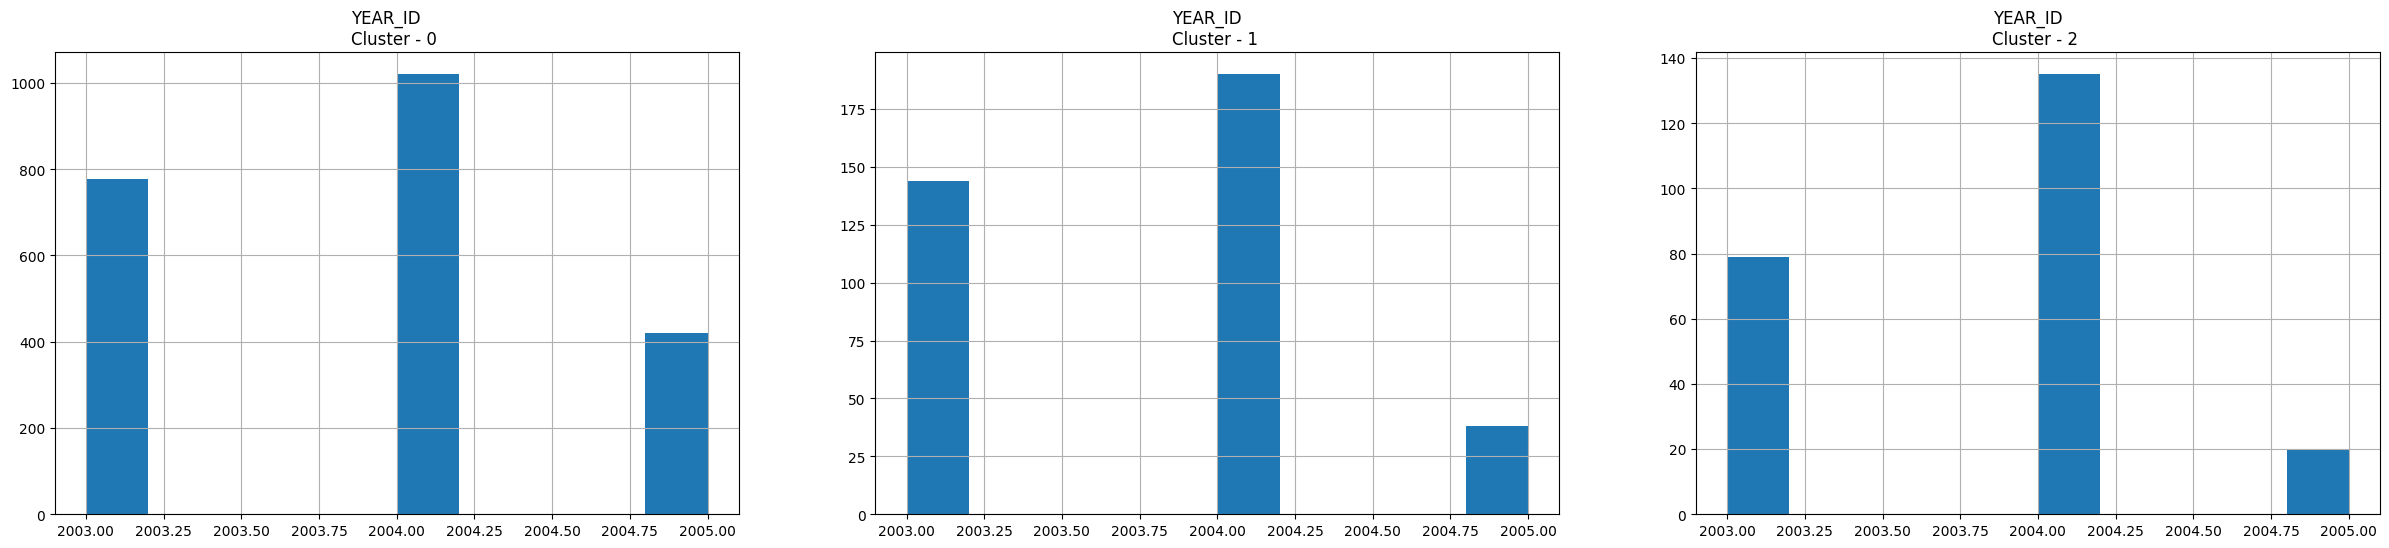

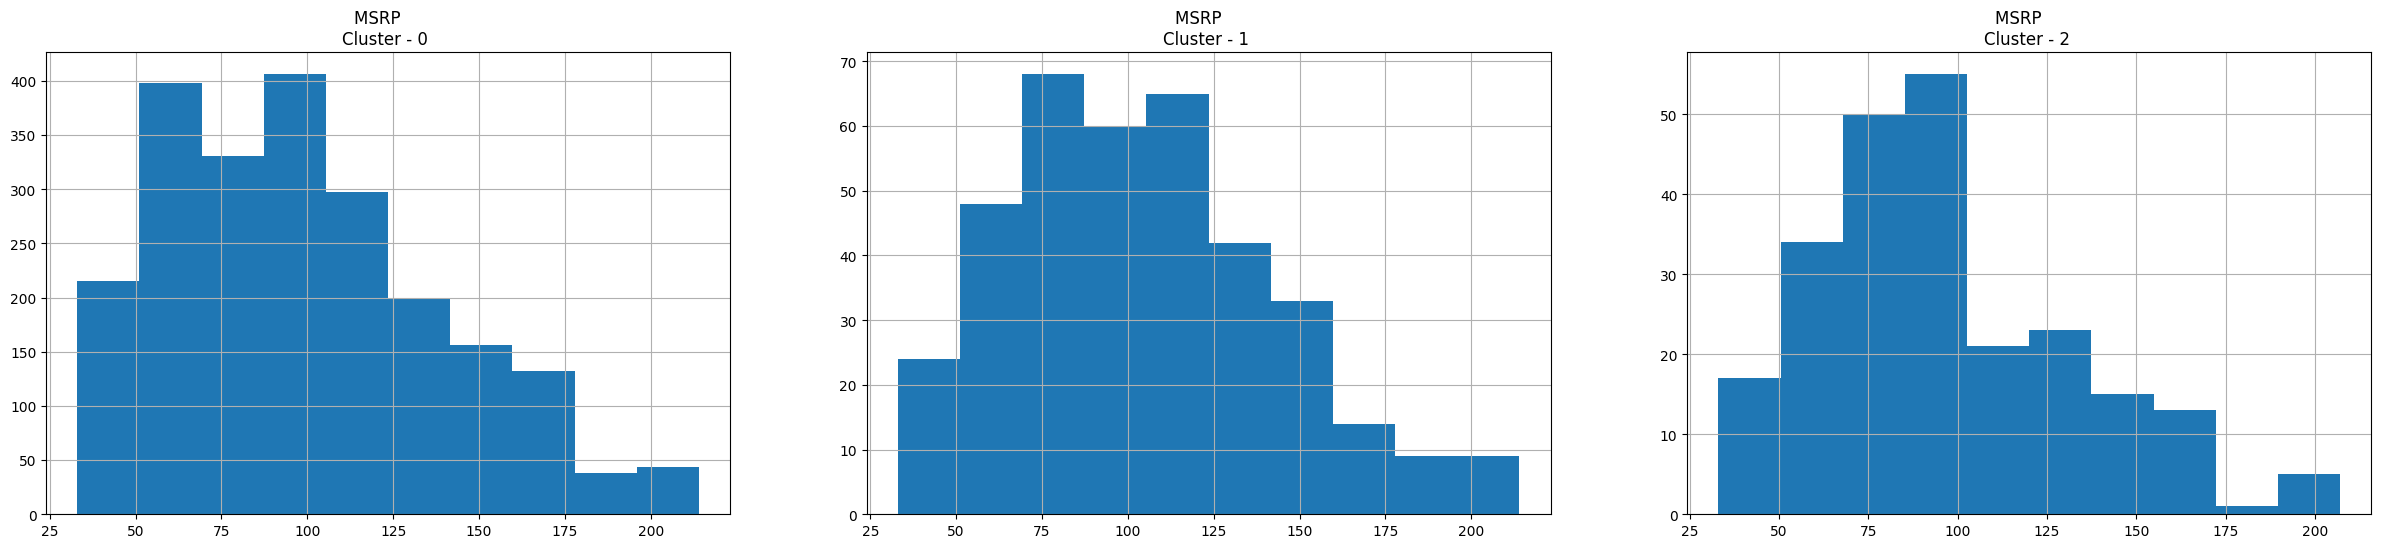

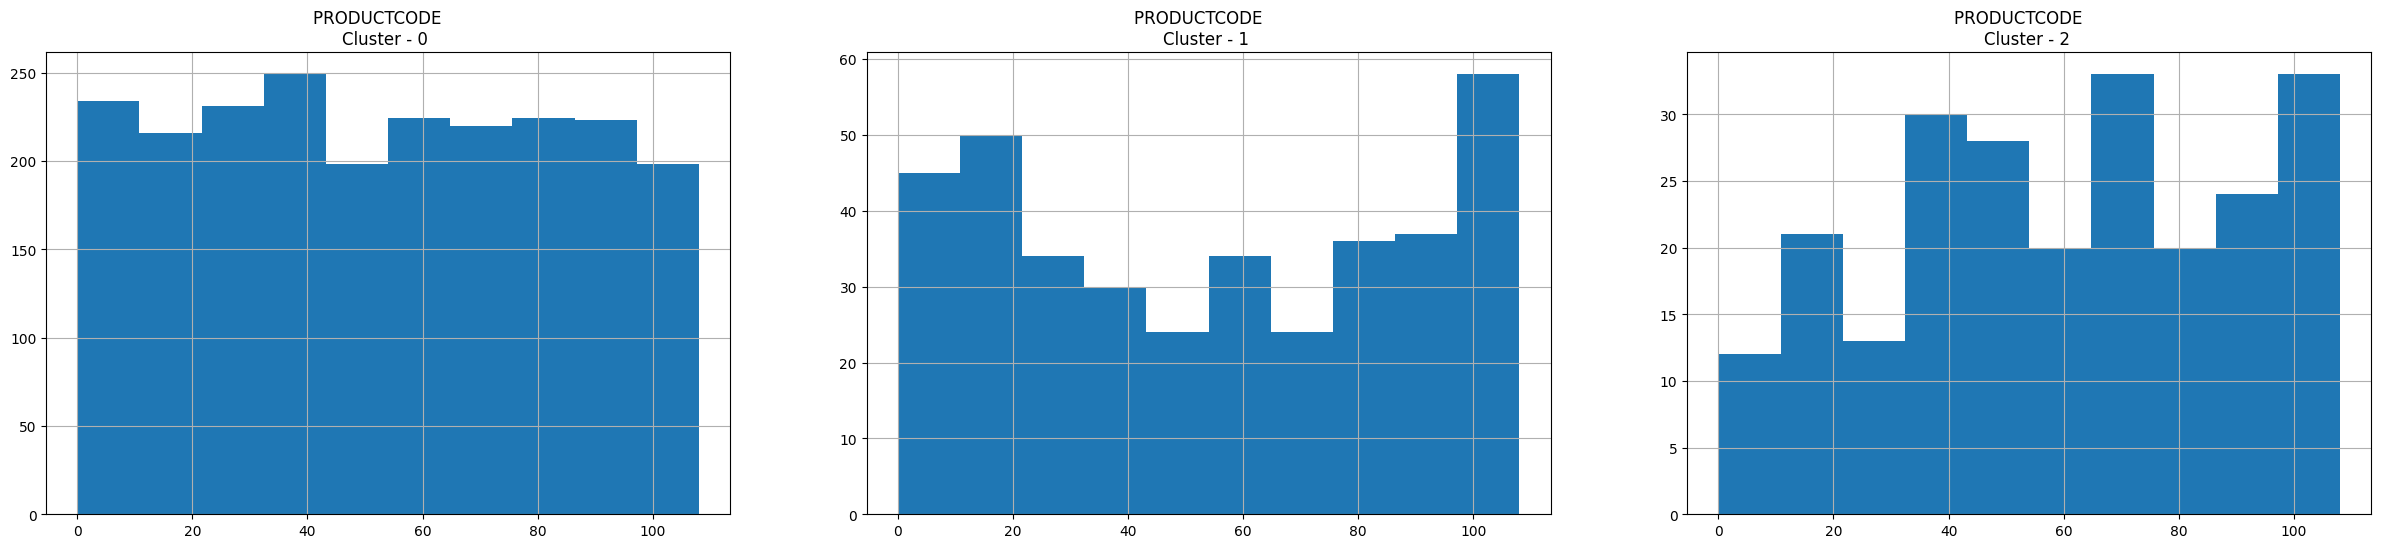

In [73]:
# plot histogram for each feature based on cluster
for i in sales_df.columns[:8]:
  plt.figure(figsize = (30, 6))
  for j in range(3):
    plt.subplot(1, 3, j+1)
    cluster = df_cluster_dr[df_cluster_dr['cluster'] == j]
    cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i,j))

  plt.show()

In [74]:
# Clúster 0: este grupo representa a los clientes que compran artículos en gran cantidad (47), por lo general compran artículos con precios altos (99). Aportan más ventas que otros grupos. En su mayoría están activos durante todo el año. Suelen comprar productos correspondientes al código de producto 10-90. Compran productos con un alto mrsp (158).
# Clúster 1: este grupo representa a los clientes que compran artículos en cantidad promedio (37) y que compran tienden a comprar artículos de precio alto (95). Aportan un promedio de ventas (4398) y están activos todo el año, son los mayores compradores de los productos correspondientes a los códigos de producto 0-10 y 90-100, además prefieren comprar productos con un PVPR elevado (115).
# Clúster 2: este grupo representa a los clientes que compran artículos en pequeñas cantidades (30), tienden a comprar artículos de bajo precio (69). Corresponden a la venta total más baja (2061) y están activos durante todo el año. Son los mayores compradores de productos correspondientes a los códigos de producto 0-20 y 100-110 y luego compran productos con PVPR bajo (77).

In [76]:
# Reducir los datos originales a 3 dimensiones usando ACP para visualizar los clústeres
pca = PCA(n_components = 3)
prin_comp = pca.fit_transform(sales_df_scaled)
pca_df = pd.DataFrame(data = prin_comp, columns = ['pca1', 'pca2', 'pca3'])
pca_df.head()

,pca1,pca2,pca3
0,-0.486319,1.195232,-1.002677
1,-0.784655,1.032832,-1.416265
2,1.431464,-0.121996,-0.281291
3,1.288425,0.218280,0.579360
4,1.976022,0.141698,1.061314


In [77]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

,pca1,pca2,pca3,cluster
0,-0.486319,1.195232,-1.002677,0
1,-0.784655,1.032832,-1.416265,0
2,1.431464,-0.121996,-0.281291,0
3,1.288425,0.218280,0.579360,0
4,1.976022,0.141698,1.061314,0


In [78]:
# Visualizar los clústers utilizando 3D-Scatterplot
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3',
              color='cluster', symbol = 'cluster', size_max = 10, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))

Texto”.- ¡EXCELENTE TRABAJO! PUEDES ESTAR ORGULLOSO DE TUS HABILIDADES RECIENTEMENTE ADQUIRIDAS

In [81]:
print(sales_df.columns)


Index(['QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER', 'SALES', 'MONTH_ID',
       'YEAR_ID', 'MSRP', 'PRODUCTCODE', 'Australia', 'Austria', 'Belgium',
       'Canada', 'Denmark', 'Finland', 'France', 'Germany', 'Ireland', 'Italy',
       'Japan', 'Norway', 'Philippines', 'Singapore', 'Spain', 'Sweden',
       'Switzerland', 'UK', 'USA', 'Classic Cars', 'Motorcycles', 'Planes',
       'Ships', 'Trains', 'Trucks and Buses', 'Vintage Cars', 'Large',
       'Medium', 'Small'],
      dtype='object')


In [84]:
# Convertir la fecha del pedido a formato datetime
sales_df['ORDERDATE'] = pd.to_datetime(sales_df['ORDERDATE'])
# Comprobar el tipo de dato
sales_df.dtypes

KeyError: 'ORDERDATE'

In [86]:
# Comprobar el número de elementos no nulos
sales_df.info()

# Comprobar el número de elementos nulos
sales_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   QUANTITYORDERED   2823 non-null   int64  
 1   PRICEEACH         2823 non-null   float64
 2   ORDERLINENUMBER   2823 non-null   float64
 3   SALES             2823 non-null   float64
 4   MONTH_ID          2823 non-null   int64  
 5   YEAR_ID           2823 non-null   int64  
 6   MSRP              2823 non-null   int64  
 7   PRODUCTCODE       2823 non-null   int8   
 8   Australia         2823 non-null   bool   
 9   Austria           2823 non-null   bool   
 10  Belgium           2823 non-null   bool   
 11  Canada            2823 non-null   bool   
 12  Denmark           2823 non-null   bool   
 13  Finland           2823 non-null   bool   
 14  France            2823 non-null   bool   
 15  Germany           2823 non-null   bool   
 16  Ireland           2823 non-null   bool   


,0
QUANTITYORDERED,0
PRICEEACH,0
ORDERLINENUMBER,0
SALES,0
MONTH_ID,0
YEAR_ID,0
MSRP,0
PRODUCTCODE,0
Australia,0
Austria,0


In [87]:
# Valores únicos de cada columna
sales_df.nunique()

,0
QUANTITYORDERED,58
PRICEEACH,1016
ORDERLINENUMBER,18
SALES,2763
MONTH_ID,12
YEAR_ID,3
MSRP,80
PRODUCTCODE,109
Australia,2
Austria,2


In [89]:
# Exploremos la columna 'ESTADO'
barplot_visualization('STATUS')

# Los datos están desbalanceados y en su mayoría contienen el estado 'enviado', eliminemos la columna 'ESTADO'
sales_df.drop(columns = ['STATUS'], inplace = True)
sales_df.shape

KeyError: 'STATUS'

In [92]:
sales_df = dummies('PRODUCTLINE')
sales_df = dummies('DEALSIZE')
sales_df

KeyError: 'PRODUCTLINE'

In [93]:
fig = px.line(x = sales_df_group.index, y = sales_df_group.SALES, title = 'Sales')
fig.show()

<Axes: >

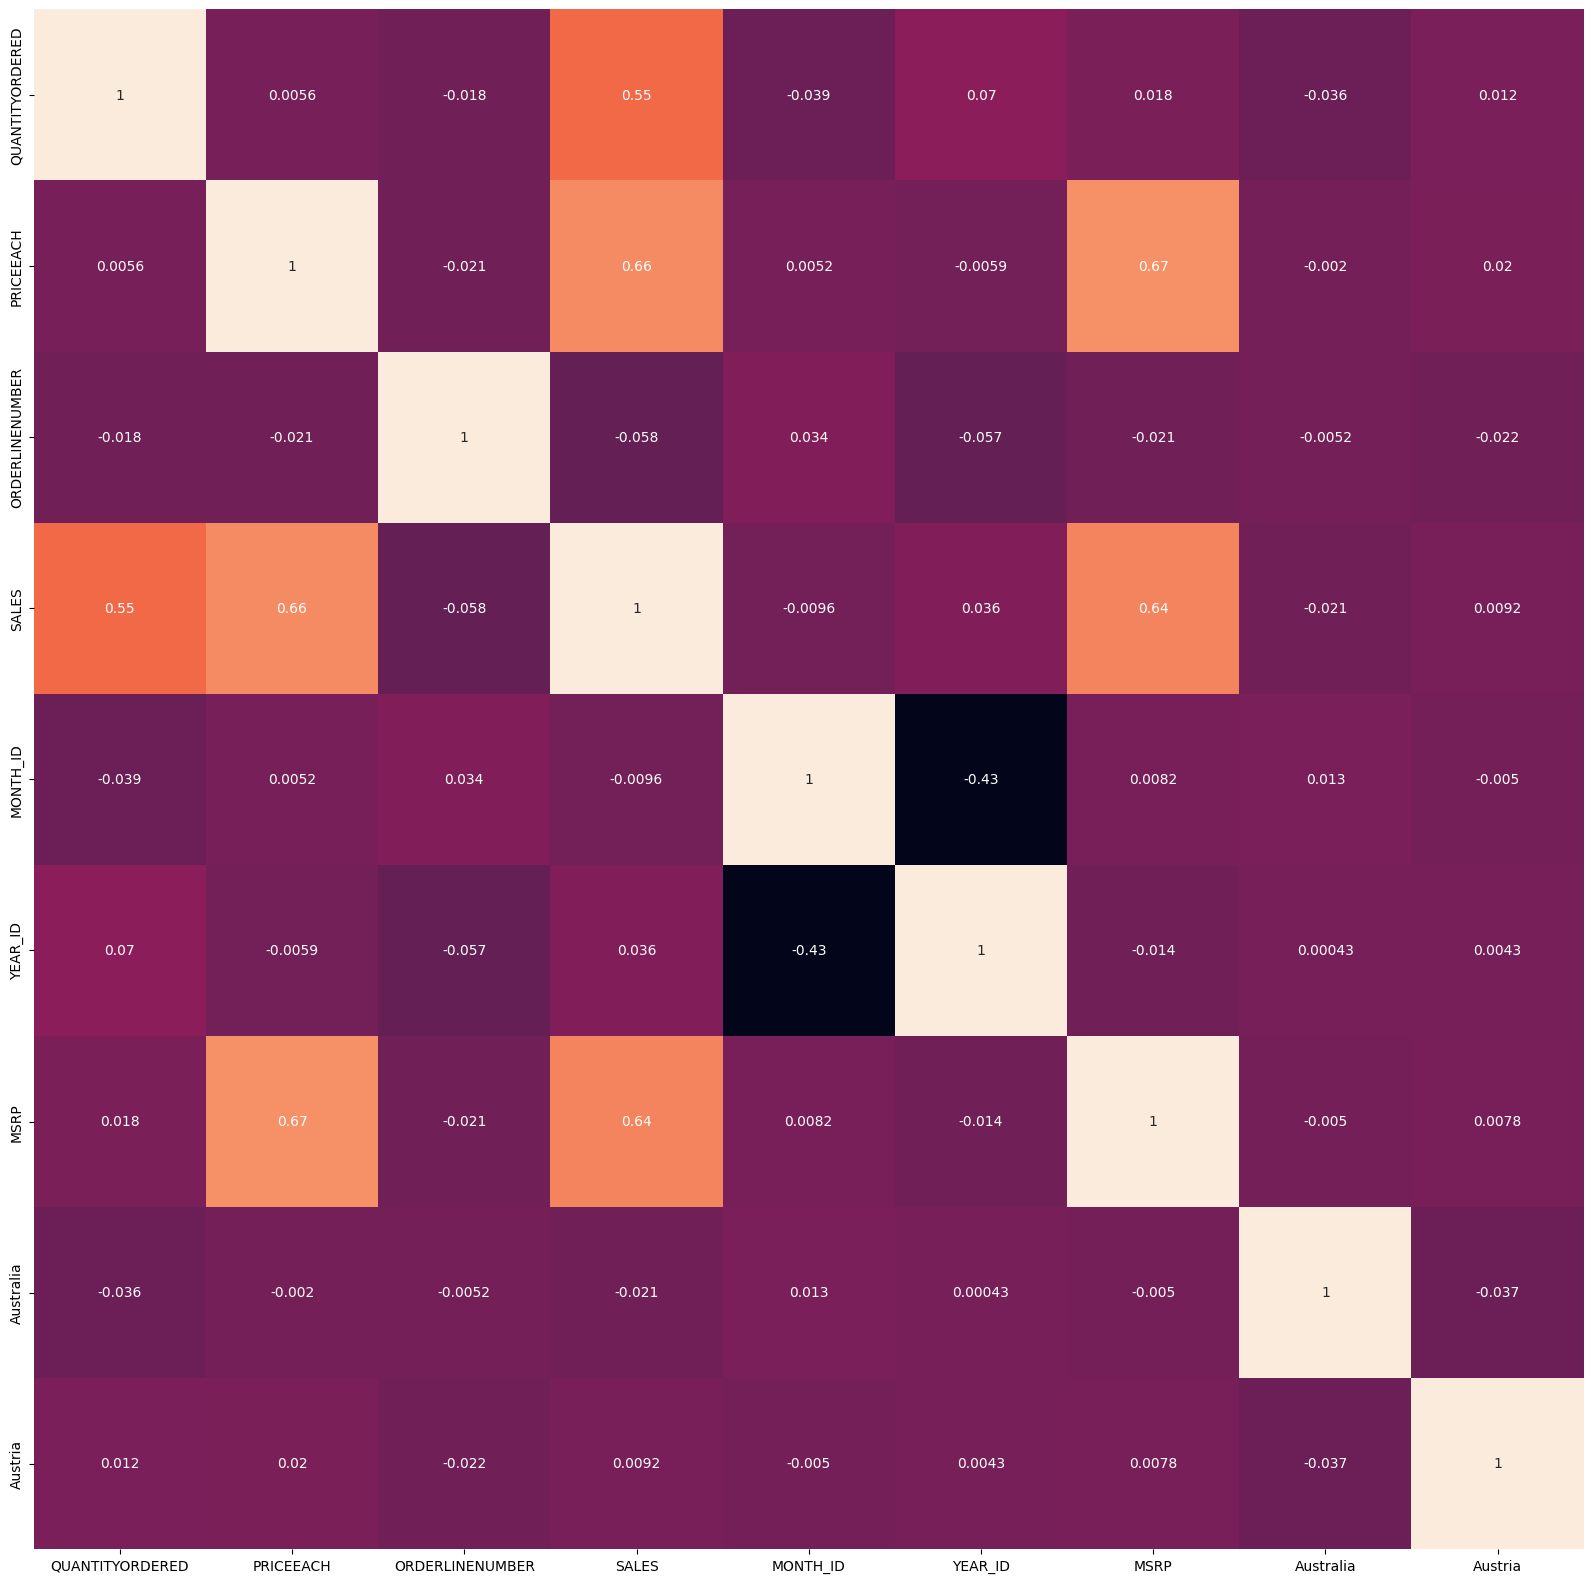

In [95]:
plt.figure(figsize = (20, 20))
corr_matrix = sales_df.iloc[:, :9].corr()
sns.heatmap(corr_matrix, annot = True, cbar = False)

<ipython-input-96-d3c74654350b>:7: UserWarning:

The palette list has more values (5) than needed (3), which may not be intended.



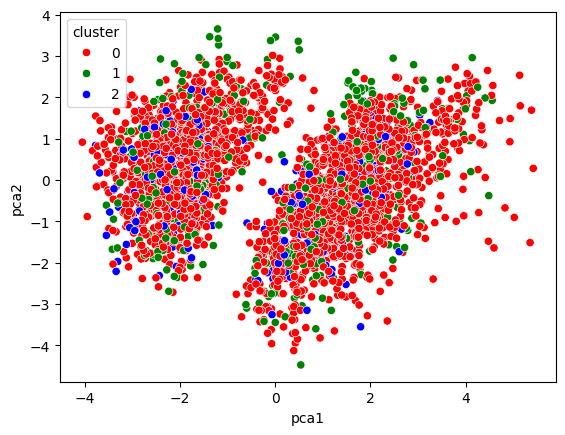

In [96]:
pca = PCA(n_components = 2)
principal_comp = pca.fit_transform(sales_df_scaled)

pca_df = pd.DataFrame(data = principal_comp, columns = ['pca1', 'pca2'])
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)

ax = sns.scatterplot(x = "pca1", y = "pca2", hue = "cluster", data = pca_df, palette = ["red", "green", "blue", "pink", "yellow"])
plt.show()